<a href="https://colab.research.google.com/github/ibenatar-96/Bayesian-Modeling-RL/blob/main/bayesian_modeling_pomdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
%cd /content/
!pip install numpyro
!pip install funsor
!git clone https://github.com/ibenatar-96/Bayesian-Modelling-RL
%cd /content/Bayesian-Modelling-RL
!git pull
%cd /content/

In [ ]:
import numpy as np
import scipy
import numpyro
import numpyro.distributions as dist
import numpyro.distributions.constraints as constraints
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import jax
import jax.numpy as jnp
import sys
import os
import time
import copy
import random
sys.path.append('/content/Bayesian-Modelling-RL')
import actions
import environment
import utils
import solver
import actions

numpyro.set_host_device_count(4)

# Intro to POMDPs

A Partially Observable Markov Decision Process (POMDP) is defined as a tuple $(S, A, T, R, Ω, O, γ)$, where:
- $S$: Finite set of states representing the environment.
- $A$: Finite set of actions available to the agent.
- $T$: State transition function $T: S \times A \mapsto S$, determining the transition probabilities between states based on actions.
- $R$: Reward function $R: S \times A \mapsto \mathbb{R}$, providing immediate rewards for actions in specific states.
- $O$: Finite set of observations that the agent can perceive.
- $Ω$: A set of conditional observation probabilities
- $γ$: The discount factor is a number ∈ $[0,1]$

# Tic-Tac-Toe Domain

Our Tic-Tac-Toe domain is composed of:

- $S$: All the possible configurations of a tic tac toe board - For each cell there could be 'X', 'O', or None (Empty).
Total of $3^{9}$ states. (Some are redundant because we will reach termination state before, for example a board with all 'X's will never be visited because we will reach terminate state after there is a row / column / diagonal with all 'X's.
- $A$: For each state, the set of possible actions are marking 'O' (functions denoted as 'ai_mark') in the empty cells of that state. For example, if our state is:
\begin{bmatrix}
    X & O & None \\
    None & O & X \\
    O & X & None
\end{bmatrix}
\
Then our actions would be:
$\{('ai\_mark', 3), ('ai\_mark', 4),('ai\_mark', 9)\}$

* $T$: Our set of conditional transition proabilities between states is initially$\mbox{*}$ defined as:
\
\begin{align}
        \text{T(s'|s,a)} = \left\{
        \begin{array}{cl}
        1.0 & a = 1,2,3,4\;and\;s \; is \; legal  \\
        0.3 & a = 5 \;and\;s \; is \; legal\\
        1.0 & a = 6,7,8,9 \;and\;s \; is \; legal\\
        \end{array}
        \right.
\end{align}
$state\;s$ is legal meaning that our board representation of $state\;s$ does not have a mark in cell $a$, alternative definition is that $s[a]=None$.
\
$\mbox{*}$ The correct / real transition of how our agent interacts with the environment is what we are trying to model and learn in this notebook.

* $R$: Our reward function is:
\begin{align}
        \text{R(r|s,a)} = \left\{
        \begin{array}{cl}
        -1 & for\;every\;action\;taken  \\
        10 & action\;a\;from\;s\;leads\;to\;terminal\;state\;and\;agent\;won\\
        -10 & action\;a\;from\;s\;leads\;to\;terminal\;state\;and\;agent\;lost\\
                0 & action\;a\;from\;s\;leads\;to\;terminal\;state\;and\;draw
        \end{array}
        \right.
\end{align}

* $Ω$: Our observation space is similar to $S$, because our partially observability is regarding what state we are in, and not partial information in the state.

* $O$: Our conditional observation probabilities function is:
\begin{align}
        \text{O(o|s',a,s)} = \left\{
        \begin{array}{cl}
        s & prob(0.3)\;and\;a=1,2 \\
        s' & prob(0.7)\;and\;a=1,2 \\
        \\
        s & prob(0.2)\;and\;a=3 \\
        s' & prob(0.8)\;and\;a=3 \\
        \\
        s & prob(0.05)\;and\;a=4 \\
        s' & prob(0.95)\;and\;a=4 \\
        \\
        ...\\
        See\;Noise\;Probabilities\;function.
        \end{array}
        \right.
\end{align}

Noise Probabilities defines our probabilities to recieve a noisy observation.
\
Meaning, we will observe the same state $s$ when $Bernoulli(Noise\_Probabilities(a))$ is true, else we recieve $observation \;s'$

* $γ$: Our gamma (discount factor) is set to be 0.95.

# Bayesian Modelling POMDPs Transition models

Our scientific problem is in the realm of planning and decision making.
\
Our assumptions our that we do not know how our model interacts with the environment (transition model with probabilities), and that an execution of a trajectory (the path of the agent through the state space up until the horizon) is costly.

Because of these assumptions, we will define a "fictive" environment - with our belief of what are the probabilities for the agent to succeed; and basically train our Agent using model-based Reinforcment Learning on that environment.

We are looking into learning the Transition Model parameters, using few observations, and improving the accuracy of our Agent through improving our belief of the transition model.

For this we will use Bayesian Modelling.

# Tic Tac Toe POMDP Domain

To show improvement in our Agent accuracy, we will define a Tic Tac Toe with probabilities domain.

We are training our AI Agent to play Tic Tac Toe, in a domain where there is a probability to successfully mark 'O' in a given cell.

The (Real) parameters (that are unknown to us) for successfully marking 'O' in a given cell are:

\begin{align}
        \text{Transition_Proability}(x) = \left\{
        \begin{array}{cl}
        1.0 & x = 1,2,3,4 \\
        0.3 & x = 5 \\
        1.0 & x = 6,7,8,9 \\
        \end{array}
        \right.
    \end{align}

Where 'x' is the cell our AI Agent is trying to mark.

Our Agent is learning using Q-Learning Reinforcment Learning algorithm, given an estimate* for his Transition Probability model.

We want to improve our estimate each iteration, and by thus improve our accuracy (how many times our AI Agent wins).

A full iteration is defined by:
    
    1. Train our AI Agent and compute an optimal policy using Q-Learning, against an optimal Tic Tac Toe opponent,
    with our model of the env. which has an estimate for each transition (cell marking) probability.

    2. Evaluate our optimal policy from clause 1 through playing against a random Tic Tac Toe opponent (uniform probability to mark 'X' in each cell).
    In this step we do not collect observations, this is done for evaluation and research only.

    3. Play 15 games and collect additional observations.

    4. Run inference on our model and observations, and improve our estimate of the transition model parameters.

\

In our Tic Tac Toe with probability domain, we are assuming that playing a game of Tic Tac Toe is expensive, so our training is done with our modelling of the environment. And in most cases we will not know our exact transition model parameters, so we are looking into Bayesian Modelling our POMDP.

\

estimate* - Our initial estimate on how the Transition model behaves is:

\begin{align}
        \text{Initial_Estimate}(x) = \left\{
        \begin{array}{cl}
        1.0 & x = 1,2,3,4 \\
        0.8 & x = 5 \\
        1.0 & x = 6,7,8,9 \\
        \end{array}
        \right.
    \end{align}

# Partial Observations

What is the probability that we will see noisy observation at cell 'x'?

Noise in our domain is observing Empty (None) instead of 'O', and vice versa.

\begin{align}
        \text{Noise_Probabilities}(x) = \left\{
        \begin{array}{cl}
        0.3 & x = 1,2 \\
        0.2 & x = 3 \\
        0.05 & x = 4 \\
        0.4 & x = 5,6 \\
        ... \\
        0.1 & x = 9
        \end{array}
        \right.
    \end{align}

\
$ Noise \;at \; cell \; 'i' = Bernoulli(Noise\_Probabilities(i)) $
\
\
$ grid[i]\; = $

$ \quad if\;(grid[i] = 'O' \; and \; not \; Noise(i)) \; OR \; (grid[i]=None \; and \; Noise(i)) \; then \; 'O' $
\
\
$ \quad else\;if\;(grid[i]='X')\; then \; 'X'$
\
\
$ \quad else\;Empty \; (None)$

\
In simple terms, if grid[i] is 'O' and there is no Noise, OR grid[i] is Empty (None) and there is Noise,
Then the belief is that grid[i] contains 'O'.

If grid[i] is 'X' OR grid[i] is Empty (None), then there is no partial observability, meaning the cell is accordingly.

If grid[i] is 'O' and there is Noise, then the belief is that grid[i] is Empty (None).

# Init Global Parameters

My assumption is that we have one Agent function - $'ai\_mark'$, that can take in 9 different parameters: 1-9.

So for example ('ai_mark', 3) will denote the action marking 'O' in cell 3.

$model\_beta\_parameters = \{(0,1):\; \{\alpha:\;1,\;\beta:1\},\;(0,2):\;\{\alpha:\;1,\;\beta:1\},\;...,\; (0,9):\; \{\alpha:\;1,\;\beta:1\}\} $
Based on bayesian_modelling_mdp.ipynb, each tuple (function, action) is initialized with a prior distribution of $Beta(1, 1)$ - which is similar to $U(0,1)$.

These are the latent variables we are trying to learn.

\

We will define a $fn\_numeric\_mapping$ dictionary that holds a mapping between function and a numeric value, this is used to infer using NumPyro (requires numbers and not string).

Again, because we are assuming only one Agent function exists ('ai_mark') we will have only one mapping - 'ai_mark': 0.

In [ ]:
noise_probabilities = [0.3, 0.3, 0.2, 0.05, 0.4, 0.15, 0.0, 0.0, 0.1]
# noise_probabilities = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
model_beta_parameters = {(0,1): {'alpha': 1, 'beta': 1}, (0,2): {'alpha': 1, 'beta': 1}, (0,3): {'alpha': 1, 'beta': 1}, (0,4): {'alpha': 1, 'beta': 1},
                          (0,5): {'alpha': 1, 'beta': 1}, (0,6): {'alpha': 1, 'beta': 1}, (0,7): {'alpha': 1, 'beta': 1}, (0,8): {'alpha': 1, 'beta': 1},
                          (0,9): {'alpha': 1, 'beta': 1}}
fn_numeric_mapping = {'ai_mark': 0}

# Creating Synthetic Observation List

Based on the Psuedo code written in the 'Partial Observations' text cell, we will create 'synthetic' observations.

In [ ]:
def create_synthetic_obs(prob_noise_vector):
    actions = [(0,1),(0,2),(0,3),(0,4),(0,5),(0,6),(0,7),(0,8),(0,9)]
    obs_list = []
    for _ in range(15):
        for action in actions:
            state = [random.choice([1,0,-1]) if cell != (action[1]-1) else 0 for cell in range(9)]
            action = action
            p_success = utils.REAL_MODEL_PARAMETERS[('ai_mark', action[1])]
            p_noise = prob_noise_vector[action[1]-1]
            success = np.random.choice([0, 1], size=1, p=[1 - p_success, p_success])
            noise = np.random.choice([0, 1], size=1, p=[1 - p_noise, p_noise])
            # success = numpyro.sample('success', dist.Bernoulli(probs=success_prob), rng_key=jax.random.PRNGKey(int(time.time() * 1E6))).item()
            # noise = numpyro.sample('noise', dist.Bernoulli(probs=noise_prob), rng_key=jax.random.PRNGKey(int(time.time() * 1E6))).item()
            next_state = copy.deepcopy(state)
            if (success and not noise) or (not success and noise):
                next_state[action[1]-1] = 1
            obs_list.append((state, action, next_state))
    return obs_list

In [ ]:
obs_list = create_synthetic_obs(noise_probabilities)
obs_list[:9]

[([0, -1, -1, 1, 1, -1, 1, 1, 0], (0, 1), [1, -1, -1, 1, 1, -1, 1, 1, 0]),
 ([-1, 0, -1, 1, -1, 1, 1, 0, 0], (0, 2), [-1, 1, -1, 1, -1, 1, 1, 0, 0]),
 ([0, -1, 0, 1, 1, 1, -1, 0, -1], (0, 3), [0, -1, 1, 1, 1, 1, -1, 0, -1]),
 ([-1, 1, -1, 0, 0, 1, 1, -1, 1], (0, 4), [-1, 1, -1, 1, 0, 1, 1, -1, 1]),
 ([-1, 0, 0, -1, 0, 1, -1, 0, 0], (0, 5), [-1, 0, 0, -1, 0, 1, -1, 0, 0]),
 ([1, 0, -1, 0, 0, 0, -1, -1, -1], (0, 6), [1, 0, -1, 0, 0, 1, -1, -1, -1]),
 ([1, 1, 1, 1, 0, 1, 0, 0, -1], (0, 7), [1, 1, 1, 1, 0, 1, 1, 0, -1]),
 ([1, 0, 1, -1, -1, -1, 1, 0, 0], (0, 8), [1, 0, 1, -1, -1, -1, 1, 1, 0]),
 ([-1, -1, 1, 1, 1, 0, 1, 0, 0], (0, 9), [-1, -1, 1, 1, 1, 0, 1, 0, 1])]

# AI Model

Defining our AI model,

We are trying to infer our Transition Model - which is defined by our 9 tuples:

('ai_mark', 1),
('ai_mark', 2),
...
('ai_mark', 9).

Our prior on these actions is:

$p('ai\_mark', \; cell) \sim Beta(1,1)$

For the ability to iterate and save our posterior Beta distributions, we will get and save our $alpha, \; beta$ parameters for our $Beta$ distributions in the global mapping dictionary - $model\_beta\_parameters$.
\
Our observation ("o" parameter) is drawn from the Bernoulli distribution, with probability: $(Action\;success\; probability) \times [1 \;-\; (Noise\; probability)] \;+\;[1 \;-\; (Action\;success\; probability)] \times (Noise\; probability) $

Our noise is modelled using the Noise_Probabilities that was defined in the Global Parameters cell.

In [ ]:
def ai_model(obs=None):
    # p ~ Beta(alpha, beta)
    p = {}
    noise = {}
    for key in model_beta_parameters.keys():
        alpha = model_beta_parameters[key]['alpha']
        beta = model_beta_parameters[key]['beta']
        p[key] = numpyro.sample(f"p{str(key)}", dist.Beta(alpha, beta))
        # p = {(0,1): sample_1, (0,2): sample_2, ..., (0,9): sample_9}
        noise[key] = numpyro.param(f"noise{str(key)}", noise_probabilities[key[1]-1])

    if obs is not None:
        p_actions = jax.numpy.array([p[action] for _, action, _ in obs]) # [sample_4, sample_5, sample_2, sample_7, sample_4, sample_5, ...]
        p_noise = jax.numpy.array([noise[action] for _, action, _ in obs], dtype='float32') # [noise_4, noise_5, noise_2, ...]
        success = jax.numpy.array([1 if state != next_state else 0 for state, _, next_state in obs]) # [1, 0, 1, 1, ...]
        with numpyro.plate("obs", size=len(obs)):
            # numpyro.sample("o", dist.Bernoulli((p_actions * (1-p_noise)) + ((1-p_actions) * p_noise)), obs=success)
            action_outcome = numpyro.sample("action_outcome", dist.Bernoulli(p_actions))
            selected_noise = jax.numpy.where(action_outcome, 1-p_noise, p_noise)
            numpyro.sample("o", dist.Bernoulli(selected_noise), obs=success)


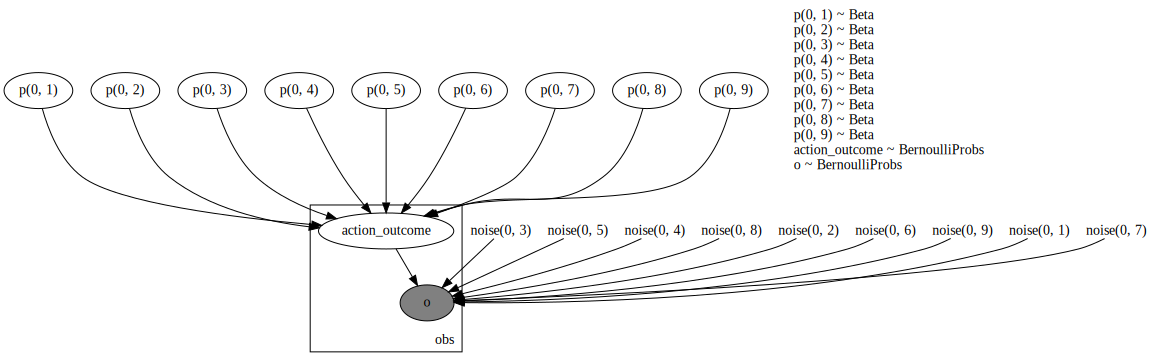

In [ ]:
numpyro.render_model(ai_model, model_args=(obs_list,), render_distributions=True, render_params=True,)

# Evaluating Prior Predictive from the Prior Distribution

Running our AI Model (without observations) to evaluate prior predictive from our prior distribution.

In our first iteration we are expecting to see around 0.5 probability for success and failure, because our prior distribution is $Beta(1,1)$ which is basically the same as $Uniform(0,1)$.

In [ ]:
def prior_predictive(ai_model):
    prior_predi = numpyro.infer.Predictive(ai_model, num_samples=10000)
    prior_samples = prior_predi(jax.random.PRNGKey(int(time.time() * 1E6)))

    num_mapping = len(model_beta_parameters.keys())
    num_rows, num_cols = utils.largest_divisors(num_mapping)
    assert num_rows * num_cols == num_mapping
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)
    plt.title("prior predictive")
    for i in range(num_rows):
        for j in range(num_cols):
            fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
            o_key = f"p{str((fn_num, action_param))}" # Need to revert this to o{str(key)}
            x_titles = ["Fail", "Success"]
            fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
            title = (fn_name, action_param)
            axs[i, j].set_title(title)
            axs[i, j].set_xlim(0, 1)
            success_counts = np.sum(prior_samples[o_key] > 0.5, axis=0)
            fail_counts = np.sum(prior_samples[o_key] < 0.5, axis=0)
            normalized_vector = [np.mean(fail_counts), np.mean(success_counts)]
            sum_normalized = np.sum(normalized_vector)
            normalized_vector /= sum_normalized
            axs[i, j].bar(x_titles, normalized_vector)
    plt.show()

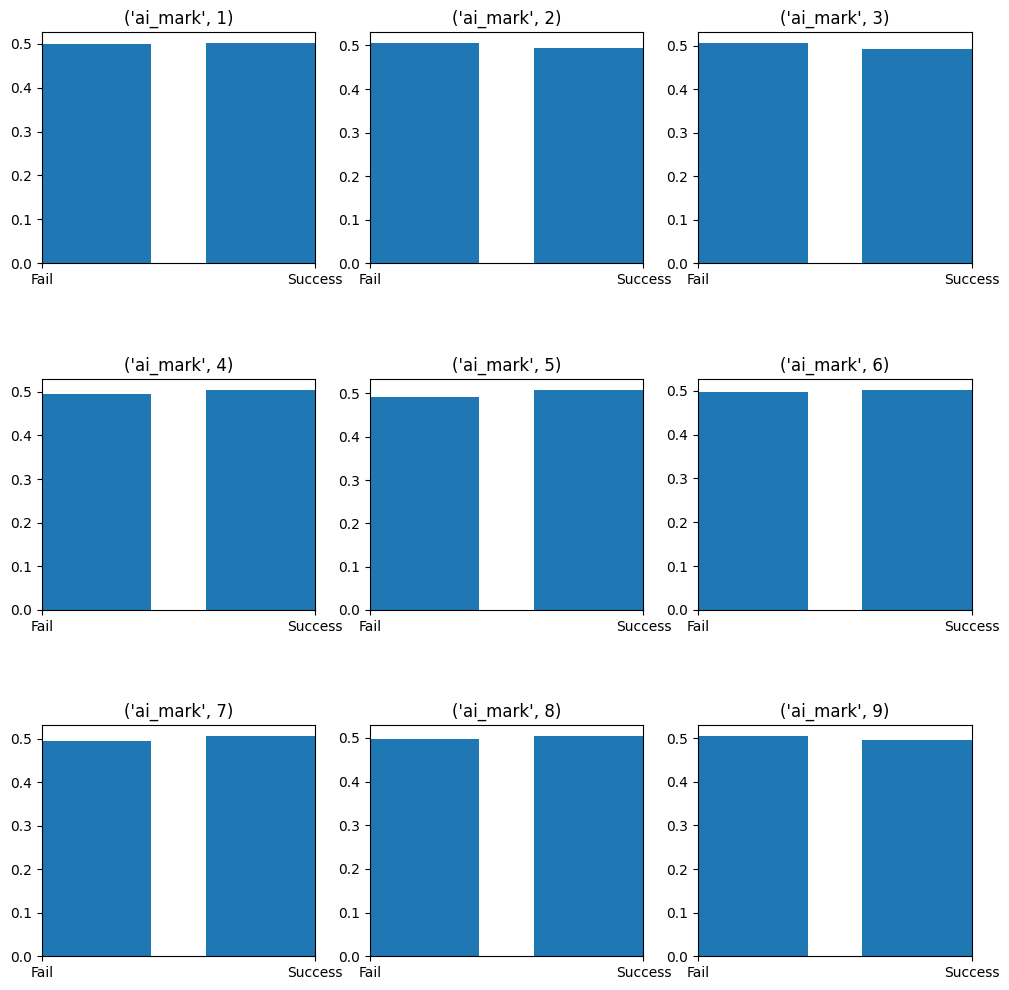

In [ ]:
prior_predictive(ai_model)

### Results

As expected, we can see that half of our predictions are fail, and half are success. This is happening because our prior distribution has no knowledge on the prior, and sampling from a Bernoulli distribution where the parameter is a sample from a Uniform distribution between 0 and 1, we are expecting for these results.

# Running Inference using MCMC.

Using MCMC sampling to approximate the posterior distribution. These samples enable estimation of posterior statistics and credible intervals.

In [ ]:
def inference(ai_model, obs):
    nuts_kernel = numpyro.infer.NUTS(ai_model)
    mcmc = numpyro.infer.MCMC(
        nuts_kernel,
        num_warmup=500,
        num_chains=4,
        num_samples=5000)
    mcmc.run(jax.random.PRNGKey(int(time.time() * 1E6)), obs=obs)
    mcmc.print_summary()
    return mcmc

In [ ]:
mcmc = inference(ai_model, obs_list)

/usr/local/lib/python3.10/dist-packages/jax/_src/linear_util.py:191: FutureWarning: Some algorithms will automatically enumerate the discrete latent site action_outcome of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   p(0, 1)      0.78      0.18      0.82      0.52      1.00  29295.88      1.00
   p(0, 2)      0.71      0.20      0.75      0.42      1.00  31347.93      1.00
   p(0, 3)      0.90      0.09      0.93      0.78      1.00  27361.71      1.00
   p(0, 4)      0.94      0.06      0.95      0.86      1.00  28667.77      1.00
   p(0, 5)      0.30      0.24      0.25      0.00      0.66  31701.22      1.00
   p(0, 6)      0.83      0.12      0.85      0.66      1.00  31742.86      1.00
   p(0, 7)      0.94      0.06      0.96      0.87      1.00  29614.64      1.00
   p(0, 8)      0.94      0.06      0.96      0.87      1.00  28154.19      1.00
   p(0, 9)      0.91      0.08      0.93      0.80      1.00  28348.06      1.00

Number of divergences: 0


# Posterior Predictive

Posterior predictive inferences involve generating simulated data based on the estimated posterior distribution from our AI model.
We are expecting to see a closer approximation to our real transition probabilities model.

Because our observation parameter is drawn from Bernoulli distribution using the 'p' latent variables, it is sufficient to analyze 'p' samples for MCMC.

In [ ]:
def posterior_predictive(ai_model, mcmc):
    num_mapping = len(model_beta_parameters.keys())
    num_rows, num_cols = utils.largest_divisors(num_mapping)
    assert num_rows * num_cols == num_mapping
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)
    plt.title("posterior")
    for i in range(num_rows):
        for j in range(num_cols):
            fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
            p_key = f"p{str((fn_num, action_param))}"
            x_titles = ["Fail", "Success"]
            fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
            title = (fn_name, action_param)
            axs[i, j].set_title(title)
            axs[i, j].set_xlim(0, 1)
            success_counts = np.sum(mcmc.get_samples()[p_key] > 0.5, axis=0)
            fail_counts = np.sum(mcmc.get_samples()[p_key] < 0.5, axis=0)
            normalized_vector = [np.mean(fail_counts), np.mean(success_counts)]
            sum_normalized = np.sum(normalized_vector)
            normalized_vector /= sum_normalized
            axs[i, j].bar(x_titles, normalized_vector)
    plt.show()

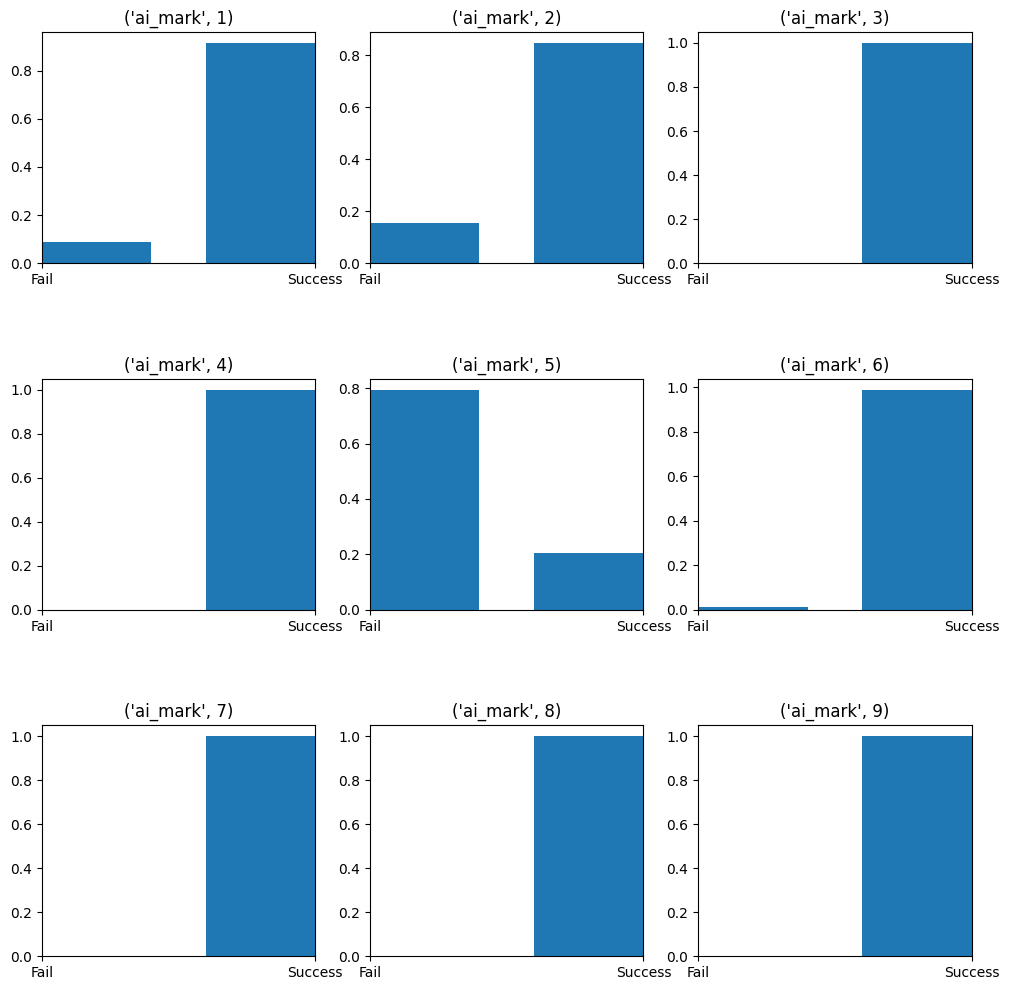

In [ ]:
posterior_predictive(ai_model, mcmc)

### Results

As expected, we can see that for variables other tahn ('ai_mark',5), the predictive mass is located in Success which is what we are expecting to see, because our real transition probabilities is 1 for each parameter other than 5.
For parameter ('ai_mark',5) we are also seeing a closer estimation of our parameter, which is about probability 0.8 of failure and 0.2 for success (where the real parameter is 0.7 and 0.3).

# Summarizing the Posterior

Summarizes Posterior, displays attributes such as mean, standard deviation, quantiles.

In [ ]:
def summarize_posterior(mcmc):
    distribution_stats = {}
    num_mapping = len(model_beta_parameters.keys())
    num_rows, num_cols = utils.largest_divisors(num_mapping)
    assert num_rows * num_cols == num_mapping
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)
    # obs_list = list(obs.items())
    for i in range(num_rows):
        for j in range(num_cols):
            fn_num, action_param = list(model_beta_parameters.keys())[i*3 + j]
            fn_name = next((k for k, v in fn_numeric_mapping.items() if v == fn_num), None)
            title = (fn_name, action_param)
            key = (fn_num, action_param)
            real_param = utils.REAL_MODEL_PARAMETERS[(fn_name, action_param)]
            p_key = f"p{str(key)}"
            p = mcmc.get_samples()[p_key]
            p_mean = p.mean()
            p_stddev = p.std()
            distribution_stats[key] = {'mean': p_mean, 'stddev': p_stddev}
            quantiles = [0, 0.025, 0.25, 0.5, 0.75, 0.975, 1]
            pq = np.quantile(p, quantiles)
            print(f"stat\t{p_key}\n-------------")
            print(f"mean\t{p_mean:.3f}")
            print(f"stddev\t{p_stddev:.3f}")
            for q in range(len(quantiles)):
                print(f"{quantiles[q] * 100:3.0f}%\t{pq[q]:.3f}")
            print("\n")
            height, _, _ = axs[i, j].hist(p, histtype="step", lw=2, bins="auto", label="posterior")
            axs[i, j].set_title(f"p{title}")
            axs[i, j].axvline(real_param, ls="dashed", color="green", label="real prob")
            axs[i, j].axvline(p_mean, ls="dashed", color="red", label="mean")
            axs[i, j].fill_betweenx([0, height.max()], pq[1], pq[-2],
                                    color="red", alpha=0.1, label=f"{(quantiles[-2] - quantiles[1]) * 100:.0f}%")
            axs[i, j].fill_betweenx([0, height.max()], pq[2], pq[-3],
                                    color="red", alpha=0.2, label=f"{(quantiles[-3] - quantiles[2]) * 100:.0f}%")
            axs[i, j].legend()
    plt.show()

stat	p(0, 1)
-------------
mean	0.775
stddev	0.178
  0%	0.003
  2%	0.342
 25%	0.672
 50%	0.817
 75%	0.918
 98%	0.992
100%	1.000


stat	p(0, 2)
-------------
mean	0.714
stddev	0.201
  0%	0.003
  2%	0.244
 25%	0.588
 50%	0.749
 75%	0.875
 98%	0.988
100%	1.000


stat	p(0, 3)
-------------
mean	0.902
stddev	0.089
  0%	0.101
  2%	0.672
 25%	0.860
 50%	0.927
 75%	0.969
 98%	0.997
100%	1.000


stat	p(0, 4)
-------------
mean	0.938
stddev	0.059
  0%	0.465
  2%	0.785
 25%	0.912
 50%	0.955
 75%	0.981
 98%	0.998
100%	1.000


stat	p(0, 5)
-------------
mean	0.304
stddev	0.236
  0%	0.000
  2%	0.010
 25%	0.111
 50%	0.249
 75%	0.450
 98%	0.862
100%	0.997


stat	p(0, 6)
-------------
mean	0.830
stddev	0.120
  0%	0.214
  2%	0.549
 25%	0.758
 50%	0.853
 75%	0.925
 98%	0.992
100%	1.000


stat	p(0, 7)
-------------
mean	0.941
stddev	0.055
  0%	0.579
  2%	0.794
 25%	0.917
 50%	0.958
 75%	0.982
 98%	0.998
100%	1.000


stat	p(0, 8)
-------------
mean	0.941
stddev	0.055
  0%	0.550
  2%	0.797
 25%	0.917
 50%	0

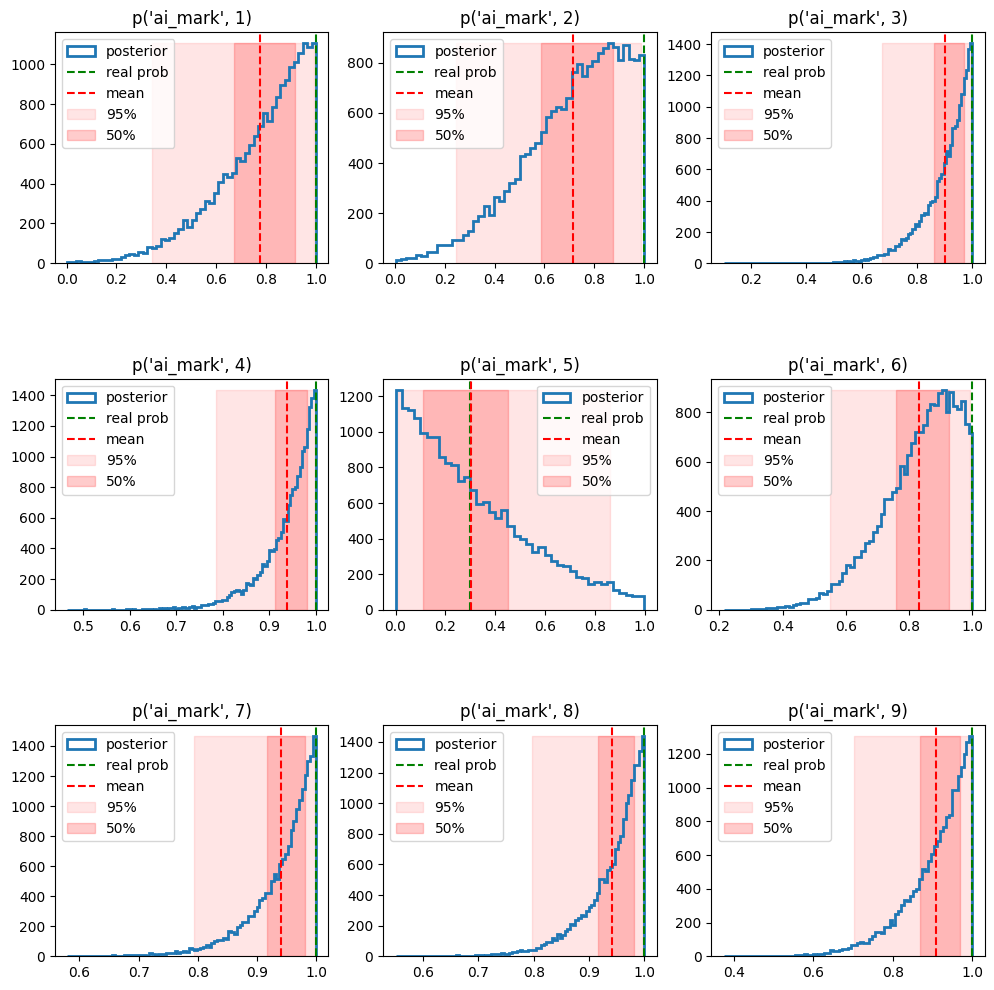

In [ ]:
summarize_posterior(mcmc)

## Next steps

Conduct two experiments,

Now we want to treat the noise as latent variables.

1st experiment: No knowledge on the prior of our noise (Beta(1,1)), and noise is independant between cells, meaning there is a different noise for each cell action.

2nd experiment: Again no knowledge on the prior of our noise (Beta(1,1)), but this time there is only one noise parameter for all of the actions.

# Noise as latent variables

Now we will try to model the noise as latent variables, meaning they are unobserved, and we will try to infer then through the (observed) data.

### Action specific noise variable

First try will be to assign a latent variable for each cell marking action. meaning there is different noise for each cell marking probability.

* In this try we will also assume that we have no knowledge on the prior of our noise.

$noise(0,i) \sim Beta(1,1)$ where 'i' indicates cell 'i'.

In [ ]:
def ai_model_unique_noise(obs=None):
    # p ~ Beta(alpha, beta)
    p = {}
    noise = {}
    for key in model_beta_parameters.keys():
        alpha = model_beta_parameters[key]['alpha']
        beta = model_beta_parameters[key]['beta']
        p[key] = numpyro.sample(f"p{str(key)}", dist.Beta(alpha, beta))
        # p = {(0,1): sample_1, (0,2): sample_2, ..., (0,9): sample_9}
        # noise[key] = numpyro.param(f"noise{str(key)}", noise_probabilities[key[1]-1])
        noise[key] = numpyro.sample(f"noise{str(key)}", dist.Beta(1, 1))

    if obs is not None:
        p_actions = jax.numpy.array([p[action] for _, action, _ in obs]) # [sample_4, sample_5, sample_2, sample_7, sample_4, sample_5, ...]
        p_noise = jax.numpy.array([noise[action] for _, action, _ in obs], dtype='float32') # [noise_4, noise_5, noise_2, ...]
        success = jax.numpy.array([1 if state != next_state else 0 for state, _, next_state in obs]) # [1, 0, 1, 1, ...]
        with numpyro.plate("obs", size=len(obs)):
            # numpyro.sample("o", dist.Bernoulli((p_actions * (1-p_noise)) + ((1-p_actions) * p_noise)), obs=success)
            action_outcome = numpyro.sample("action_outcome", dist.Bernoulli(p_actions))
            selected_noise = jax.numpy.where(action_outcome, 1-p_noise, p_noise)
            numpyro.sample("o", dist.Bernoulli(selected_noise), obs=success)


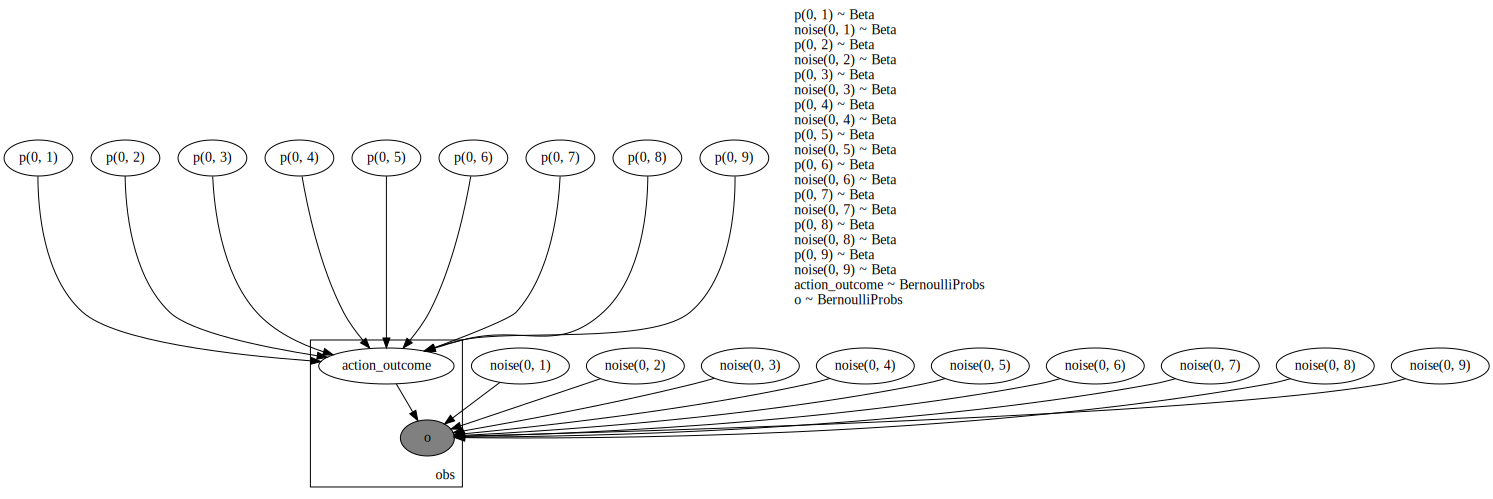

In [ ]:
numpyro.render_model(ai_model_unique_noise, model_args=(obs_list,), render_distributions=True, render_params=True,)

In [ ]:
mcmc_unique = inference(ai_model_unique_noise, obs_list)

/usr/local/lib/python3.10/dist-packages/jax/_src/linear_util.py:191: FutureWarning: Some algorithms will automatically enumerate the discrete latent site action_outcome of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  noise(0, 1)      0.50      0.30      0.49      0.00      0.90   3500.40      1.00
  noise(0, 2)      0.50      0.27      0.50      0.04      0.91   7123.33      1.00
  noise(0, 3)      0.44      0.40      0.20      0.00      0.97     49.81      1.14
  noise(0, 4)      0.60      0.43      0.89      0.02      1.00     14.03      1.30
  noise(0, 5)      0.51      0.30      0.51      0.04      0.94   3429.50      1.00
  noise(0, 6)      0.50      0.34      0.49      0.04      0.97   1387.81      1.00
  noise(0, 7)      0.54      0.44      0.83      0.02      1.00     17.08      1.29
  noise(0, 8)      0.52      0.44      0.80      0.02      1.00     19.46      1.04
  noise(0, 9)      0.50      0.41      0.47      0.01      0.98    133.03      1.04
      p(0, 1)      0.50      0.30      0.51      0.04      0.93   3526.96      1.00
      p(0, 2)      0.50      0.27      0.50      0.04      0.91   7276.22  

## Results

As expected we can see a relation between noise(0, i) to p(0, i).
This also makes sense, because if our noise parameter will be higher then our cell mark probability will be lower.
\
This is due to the fact that when my noise will be higher, the probability of marking a cell will be lower because each observation will be noisy.
and the opposite also holds, when the noise will be smaller, the probility of marking a cell will be higher becuase each observation will be a true success and not a noisy one.

In [ ]:
def summarize_correlations(mcmc, common=False):
    p_samples = {key: mcmc.get_samples()[f"p{str(key)}"] for key in model_beta_parameters.keys()}
    if common:
        noise_samples = {key: mcmc.get_samples()[f"noise"] for key in model_beta_parameters.keys()}
    else:
        noise_samples = {key: mcmc.get_samples()[f"noise{str(key)}"] for key in model_beta_parameters.keys()}

    # Calculate correlation between p and noise for each key
    correlations = {key: np.corrcoef(p_samples[key], noise_samples[key])[0, 1] for key in model_beta_parameters.keys()}
    print("Correlations between p and noise:")
    for key, correlation in correlations.items():
        print(f"Key {key}: {correlation}")

    correlation_values = [correlations[key] for key in model_beta_parameters.keys()]
    keys = [str(key) for key in model_beta_parameters.keys()]

    plt.figure(figsize=(10, 6))
    plt.scatter(keys, correlation_values, color='blue')
    for i, txt in enumerate(correlation_values):
        plt.annotate(f'{txt:.2f}', (keys[i], correlation_values[i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.xlabel('Keys')
    plt.ylabel('Correlation')
    plt.title('Correlations between p and noise for each key')
    plt.xticks(rotation=45)
    plt.ylim(-1, 1)  # Set y-axis limits to display range from -1 to 1
    plt.grid(axis='both', linestyle='--')
    plt.show()

Correlations between p and noise:
Key (0, 1): -0.7474466722094713
Key (0, 2): -0.5929093480551051
Key (0, 3): -0.9592698428365338
Key (0, 4): -0.9823146658772087
Key (0, 5): 0.7542805754673236
Key (0, 6): -0.8561397150382848
Key (0, 7): -0.9826723600438579
Key (0, 8): -0.9826105978977133
Key (0, 9): -0.9597412497282102


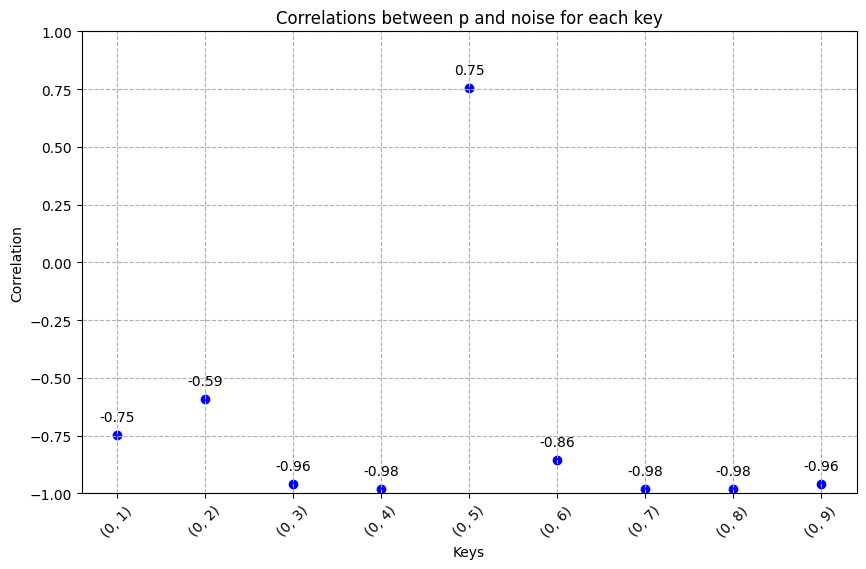

In [ ]:
summarize_correlations(mcmc_unique)

### Correlations

We can see that for most of the keys we are getting a strong negative linear relationship between the two variables, implying that as one variable increases, the other tends to decrease in a consistent and predictable manner.

## Common Observational Noise

Now we will try to assign a common (shared) noise variable to all actions.

This behaviour is closer to the real world because the observations are coming from the same sensor.

Lets create synthetic observation data based on:
1. \begin{align}
        \text{Transition_Proability}(x) = \left\{
        \begin{array}{cl}
        1.0 & x = 1,2,3,4 \\
        0.3 & x = 5 \\
        1.0 & x = 6,7,8,9 \\
        \end{array}
        \right.
    \end{align}

2. \begin{align}
        \text{Noise_Probability} = 0.15
    \end{align}

* Our assumptions are that we have no knowledge on the prior of our noise.

$noise \sim Beta(1,1)$

In [ ]:
noise_probability = 0.25
common_noise_obs = create_synthetic_obs([noise_probability]*9)
common_noise_obs[:9]

[([0, 1, 0, 1, -1, 1, -1, 0, 0], (0, 1), [0, 1, 0, 1, -1, 1, -1, 0, 0]),
 ([0, 0, -1, -1, 1, -1, 0, -1, 1], (0, 2), [0, 1, -1, -1, 1, -1, 0, -1, 1]),
 ([0, 1, 0, -1, -1, -1, 1, -1, -1], (0, 3), [0, 1, 1, -1, -1, -1, 1, -1, -1]),
 ([0, 0, -1, 0, 0, 1, -1, -1, 0], (0, 4), [0, 0, -1, 1, 0, 1, -1, -1, 0]),
 ([1, -1, 1, 1, 0, -1, 0, -1, -1], (0, 5), [1, -1, 1, 1, 0, -1, 0, -1, -1]),
 ([1, 1, -1, 0, -1, 0, 0, 1, 0], (0, 6), [1, 1, -1, 0, -1, 1, 0, 1, 0]),
 ([0, -1, 0, 0, 0, 1, 0, 0, 1], (0, 7), [0, -1, 0, 0, 0, 1, 0, 0, 1]),
 ([0, 0, -1, 0, 0, 1, -1, 0, -1], (0, 8), [0, 0, -1, 0, 0, 1, -1, 1, -1]),
 ([0, 0, 1, 0, 1, -1, 0, 0, 0], (0, 9), [0, 0, 1, 0, 1, -1, 0, 0, 0])]

In [ ]:
def ai_model_common_noise(obs=None):
    # p ~ Beta(alpha, beta)
    p = {}
    noise = numpyro.sample(f"noise", dist.Beta(1, 1))
    for key in model_beta_parameters.keys():
        alpha = model_beta_parameters[key]['alpha']
        beta = model_beta_parameters[key]['beta']
        p[key] = numpyro.sample(f"p{str(key)}", dist.Beta(alpha, beta))
        # p = {(0,1): sample_1, (0,2): sample_2, ..., (0,9): sample_9}

    if obs is not None:
        p_actions = jax.numpy.array([p[action] for _, action, _ in obs]) # [sample_4, sample_5, sample_2, sample_7, sample_4, sample_5, ...]
        p_noise = jax.numpy.array([noise for _, action, _ in obs], dtype='float32') # [noise_4, noise_5, noise_2, ...]
        success = jax.numpy.array([1 if state != next_state else 0 for state, _, next_state in obs]) # [1, 0, 1, 1, ...]
        with numpyro.plate("obs", size=len(obs)):
            # numpyro.sample("o", dist.Bernoulli((p_actions * (1-p_noise)) + ((1-p_actions) * p_noise)), obs=success)
            action_outcome = numpyro.sample("action_outcome", dist.Bernoulli(p_actions))
            selected_noise = jax.numpy.where(action_outcome, 1-p_noise, p_noise)
            numpyro.sample("o", dist.Bernoulli(selected_noise), obs=success)

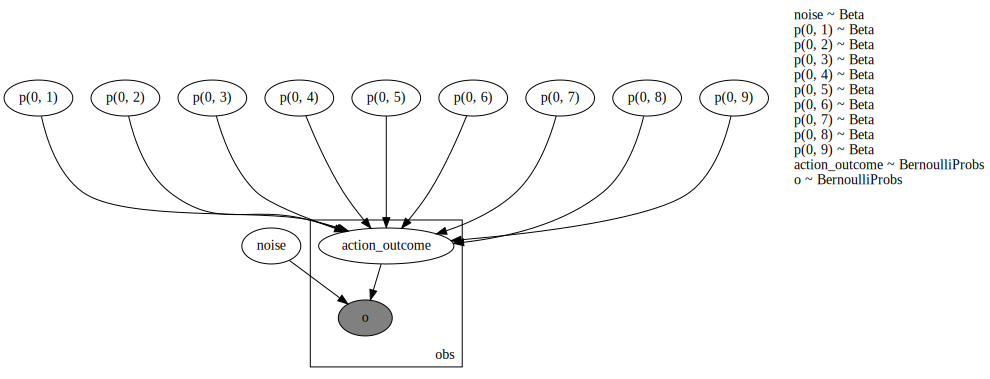

In [ ]:
numpyro.render_model(ai_model_common_noise, model_args=(common_noise_obs,), render_distributions=True, render_params=True,)

In [ ]:
mcmc_common = inference(ai_model_common_noise, common_noise_obs)

/usr/local/lib/python3.10/dist-packages/jax/_src/linear_util.py:191: FutureWarning: Some algorithms will automatically enumerate the discrete latent site action_outcome of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     noise      0.69      0.34      0.86      0.08      0.99      2.05      5.98
   p(0, 1)      0.34      0.30      0.23      0.00      0.86      2.30      2.62
   p(0, 2)      0.48      0.16      0.48      0.22      0.75     58.14      1.03
   p(0, 3)      0.32      0.33      0.16      0.00      0.91      2.15      3.54
   p(0, 4)      0.32      0.33      0.16      0.00      0.91      2.16      3.46
   p(0, 5)      0.56      0.18      0.57      0.25      0.86      5.87      1.21
   p(0, 6)      0.37      0.26      0.29      0.00      0.80      2.58      2.01
   p(0, 7)      0.44      0.18      0.43      0.15      0.75      5.96      1.21
   p(0, 8)      0.32      0.33      0.16      0.00      0.91      2.16      3.47
   p(0, 9)      0.34      0.30      0.22      0.00      0.86      2.29      2.67

Number of divergences: 0


Correlations between p and noise:
Key (0, 1): -0.8893254509164636
Key (0, 2): -0.20036384082229244
Key (0, 3): -0.9335032729898128
Key (0, 4): -0.9319120717840592
Key (0, 5): 0.518897025418383
Key (0, 6): -0.8240132334931504
Key (0, 7): -0.5171144222032776
Key (0, 8): -0.932076984724613
Key (0, 9): -0.8930918337830145


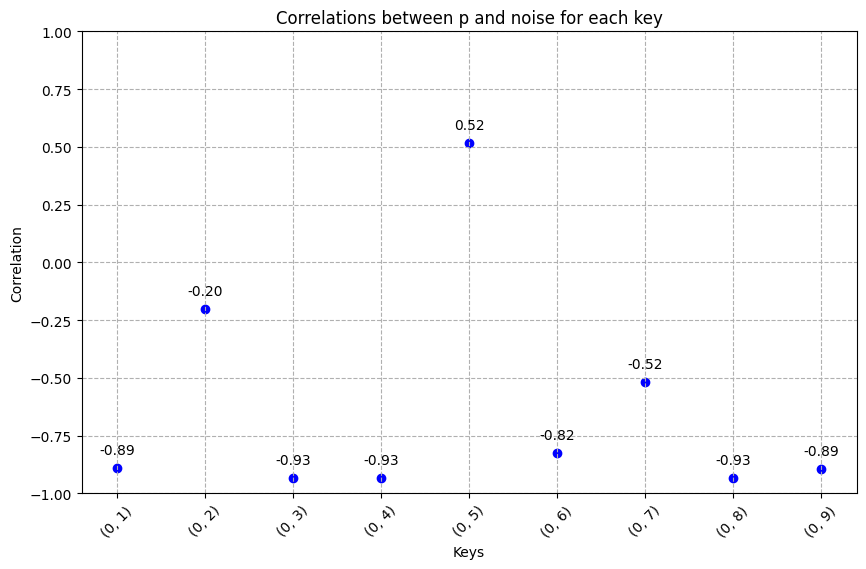

In [ ]:
summarize_correlations(mcmc_common, common=True)

# Beta(1, 3) Common Noise

Lets assume that we have a stronger prior on our noise parameter, and there were 2 observations that we know that are not noisy, this gives us a stronger prior and we can assume that our noise parameter can take values from Beta(1, 3) distribution.

$noise\sim Beta(1,3)$


In [ ]:
def ai_model_beta_noise(obs=None):
    # p ~ Beta(alpha, beta)
    p = {}
    noise = numpyro.sample(f"noise", dist.Beta(1, 3))
    for key in model_beta_parameters.keys():
        alpha = model_beta_parameters[key]['alpha']
        beta = model_beta_parameters[key]['beta']
        p[key] = numpyro.sample(f"p{str(key)}", dist.Beta(alpha, beta))
        # p = {(0,1): sample_1, (0,2): sample_2, ..., (0,9): sample_9}

    if obs is not None:
        p_actions = jax.numpy.array([p[action] for _, action, _ in obs]) # [sample_4, sample_5, sample_2, sample_7, sample_4, sample_5, ...]
        p_noise = jax.numpy.array([noise for _, action, _ in obs], dtype='float32') # [noise_4, noise_5, noise_2, ...]
        success = jax.numpy.array([1 if state != next_state else 0 for state, _, next_state in obs]) # [1, 0, 1, 1, ...]
        with numpyro.plate("obs", size=len(obs)):
            # numpyro.sample("o", dist.Bernoulli((p_actions * (1-p_noise)) + ((1-p_actions) * p_noise)), obs=success)
            action_outcome = numpyro.sample("action_outcome", dist.Bernoulli(p_actions))
            selected_noise = jax.numpy.where(action_outcome, 1-p_noise, p_noise)
            numpyro.sample("o", dist.Bernoulli(selected_noise), obs=success)

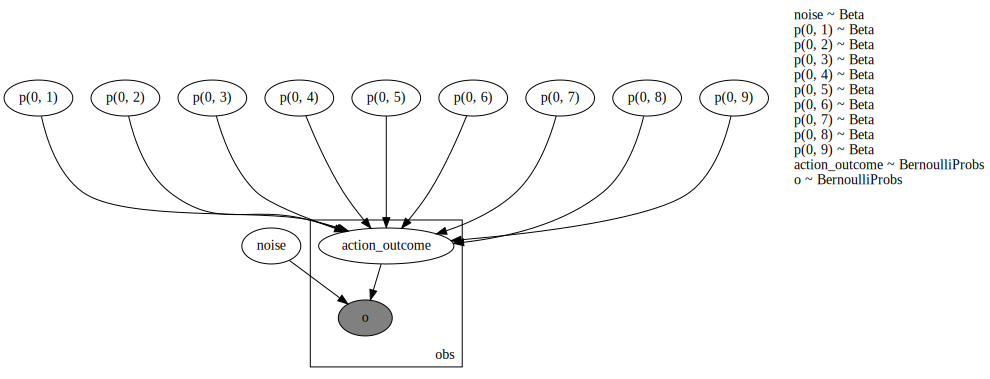

In [ ]:
numpyro.render_model(ai_model_beta_noise, model_args=(common_noise_obs,), render_distributions=True, render_params=True,)

In [ ]:
mcmc_beta = inference(ai_model_beta_noise, common_noise_obs)

/usr/local/lib/python3.10/dist-packages/jax/_src/linear_util.py:191: FutureWarning: Some algorithms will automatically enumerate the discrete latent site action_outcome of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     noise      0.29      0.32      0.13      0.00      0.85      2.05      5.83
   p(0, 1)      0.65      0.30      0.77      0.12      1.00      2.29      2.65
   p(0, 2)      0.52      0.16      0.52      0.25      0.79     52.65      1.03
   p(0, 3)      0.68      0.33      0.84      0.08      1.00      2.15      3.52
   p(0, 4)      0.68      0.33      0.83      0.08      1.00      2.16      3.51
   p(0, 5)      0.45      0.19      0.43      0.15      0.76      5.60      1.23
   p(0, 6)      0.62      0.26      0.70      0.17      0.99      2.55      2.05
   p(0, 7)      0.55      0.19      0.57      0.22      0.85      5.66      1.22
   p(0, 8)      0.68      0.33      0.84      0.08      1.00      2.15      3.51
   p(0, 9)      0.65      0.30      0.77      0.12      1.00      2.28      2.68

Number of divergences: 0


Correlations between p and noise:
Key (0, 1): -0.8914562665939685
Key (0, 2): -0.19871169063662614
Key (0, 3): -0.9325339301156469
Key (0, 4): -0.9325439578643385
Key (0, 5): 0.5337247623991146
Key (0, 6): -0.8291043760478983
Key (0, 7): -0.5287777648745086
Key (0, 8): -0.9325150140325388
Key (0, 9): -0.8948893831661776


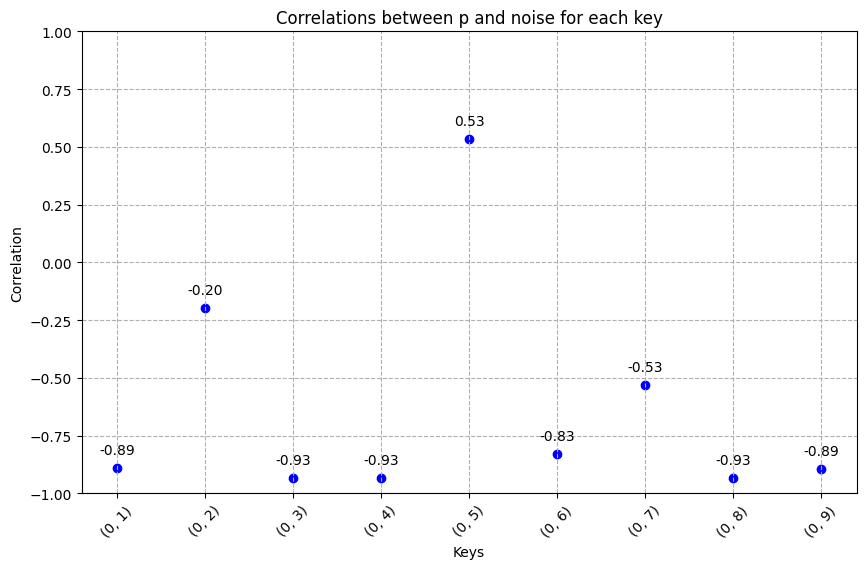

In [ ]:
summarize_correlations(mcmc_beta, common=True)

stat	noise
-------------
mean	0.287
stddev	0.319
  0%	0.000
  2%	0.012
 25%	0.076
 50%	0.129
 75%	0.423
 98%	0.905
100%	0.983




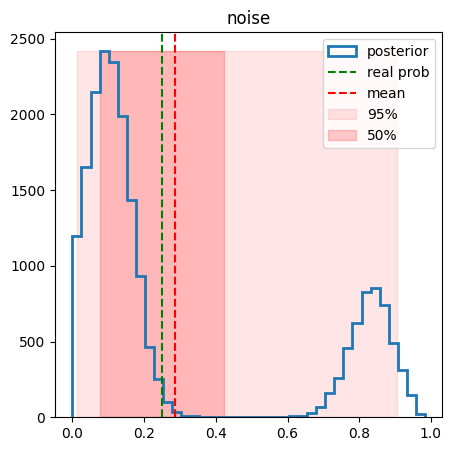

In [ ]:
distribution_stats = {}
real_param = noise_probability
noise = mcmc_beta.get_samples()["noise"]
noise_mean = noise.mean()
noise_stddev = noise.std()
distribution_stats['noise'] = {'mean': noise_mean, 'stddev': noise_stddev}
quantiles = [0, 0.025, 0.25, 0.5, 0.75, 0.975, 1]
pq = np.quantile(noise, quantiles)
print(f"stat\tnoise\n-------------")
print(f"mean\t{noise_mean:.3f}")
print(f"stddev\t{noise_stddev:.3f}")
for q in range(len(quantiles)):
    print(f"{quantiles[q] * 100:3.0f}%\t{pq[q]:.3f}")
print("\n")
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
height, _, _ = axs.hist(noise, histtype="step", lw=2, bins="auto", label="posterior")
axs.set_title(f"noise")
axs.axvline(real_param, ls="dashed", color="green", label="real prob")
axs.axvline(noise_mean, ls="dashed", color="red", label="mean")
axs.fill_betweenx([0, height.max()], pq[1], pq[-2],
                        color="red", alpha=0.1, label=f"{(quantiles[-2] - quantiles[1]) * 100:.0f}%")
axs.fill_betweenx([0, height.max()], pq[2], pq[-3],
                        color="red", alpha=0.2, label=f"{(quantiles[-3] - quantiles[2]) * 100:.0f}%")
axs.legend()

# Partial Pooling - Hierarchical Model

Explanation of Pooling Techniques

Complete Pooling: Combines all data without distinguishing between groups. It assumes a single parameter for the entire dataset, ignoring group-specific differences. For example, in tic-tac-toe, it estimates one success probability for all cells.

No Pooling (Separate Models): Fits separate models for each group, treating them independently with no information sharing. In the tic-tac-toe context, it estimates success probabilities for marking different cells without considering relationships between them.

Partial Pooling (Hierarchical Model): Strikes a balance between complete pooling and no pooling. It estimates both local (group-specific) parameters and a global (overall) parameter. In tic-tac-toe, it estimates success probabilities for each cell while considering an overarching success probability that influences all cells.

**Notation:**

$\theta_i$: True probability to succesfully mark 'O' in cell $i$

$y_i$: Number of overall successes when marking 'O' in cell $i$

$n_i$: Number of overall attempts to mark 'O' in cell $i$
\
\
**Probabilities:**

$p(y_i|n_i,θ_i) \sim Binomial(n_i,\theta_i)$

$p(\theta_i|\mu,\kappa) \sim Beta(\mu \kappa, (1-\mu)\kappa)$

\
*_Side note_:
We might consider $\theta \sim \text{Beta}(\alpha,\beta)$, however it is more convenient to reparametrize a Beta dist. in terms of its mean $\mu=\alpha/(\alpha+\beta)$ and concentration $\kappa=\alpha+\beta$. Opening and isolating $\alpha$ and $\beta$ gives us $\alpha=\mu\kappa$ and $\beta=(1-\mu)\kappa$.

\

**Hyperpriors:**

$\mu$ This is the mean of the prior distribution. In the context of the beta distribution, μ represents the expected value or the average probability. It is a number between 0 and 1, inclusive, and it characterizes the center or central tendency of the prior distribution.

$\kappa$ This is a measure of the "peakiness" or concentration of the prior density. Higher values of $\kappa$ correspond to a more peaked density, while lower values of $\kappa$ lead to a more spread-out or flat density. When $\kappa$ is small, it means the prior is less informative, and the posterior distribution will rely more on the data. When $\kappa$ is large, the prior is more informative and can strongly influence the posterior.

_Alternative definition_:\
$\kappa$ represents the “equivalent prior sample size” upon which our beliefs about $\theta$ are based.\
A Gamma(1, 0.1) prior has mean 10 and standard deviation 10. So we’re saying our prior beliefs about $\theta$ are likely based on an “equivalent prior sample size” in the single digits or a few tens (but not hundreds or thousands) of pseudo-observations. This is like saying we haven’t observed any actions, so we don’t have much information about the other actions distribution or action-to-action variability of marking cells.

\
$\mu \sim Beta(8,2)$

$\kappa \sim Gamma(1, 0.1)$


kappa mean: 199.4166552740302
kappa_2 mean: 20.125819872803284
kappa_3 mean: 199.55904841404245


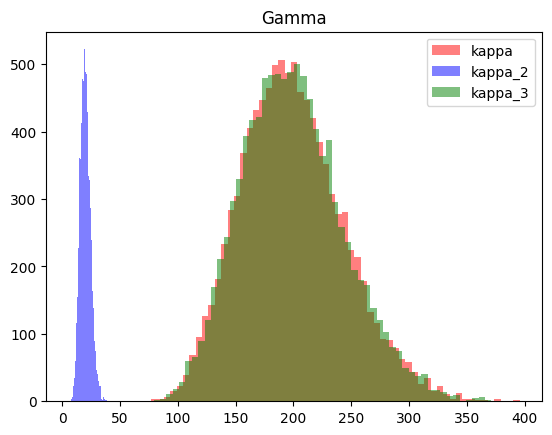

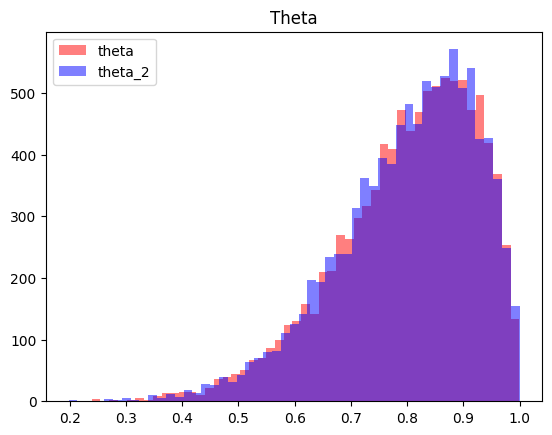

In [ ]:
N = 10000
# mu = scipy.stats.beta(8, 2).rvs(N)
mu = scipy.stats.beta.rvs(a=8, b=2, size=N)
kappa = scipy.stats.gamma.rvs(a=20, scale=10, size=N) # follows rate and scale parameters.
kappa_2 = scipy.stats.gamma(20, 1/10).rvs(N)
kappa_3 = scipy.stats.gamma(20, scale=10).rvs(N)
# kappa_mean = np.mean(kappa)
print(f"kappa mean: {np.mean(kappa)}\nkappa_2 mean: {np.mean(kappa_2)}\nkappa_3 mean: {np.mean(kappa_3)}")

plt.hist(kappa, bins='auto', color='red', label='kappa', alpha=0.5)
plt.hist(kappa_2, bins='auto', color='blue', label='kappa_2', alpha=0.5)
plt.hist(kappa_3, bins='auto', color='green', label='kappa_3', alpha=0.5)
plt.title("Gamma")
plt.legend()
plt.show()

theta = scipy.stats.beta.rvs(a=mu*kappa, b=(1 - mu)*kappa, size=N)
theta_2 = scipy.stats.beta(mu*kappa, (1 - mu)*kappa).rvs(N)

plt.hist(theta, bins='auto', color='red', label='theta', alpha=0.5)
plt.hist(theta_2, bins='auto', color='blue', label='theta_2', alpha=0.5)
plt.title("Theta")
plt.legend()
plt.show()

### $1^{st}$ Try

Treating each observation on it's own,

$\mu$ and $\kappa$ are defined the same, but for each observation $y_i$:

$p(y_i|\theta_i) \sim Bernoulli(\theta_i)$

In [ ]:
no_noise_obs = create_synthetic_obs([0]*9)
no_noise_obs[:9]

[([0, -1, 0, 1, 0, 0, 0, 1, -1], (0, 1), [1, -1, 0, 1, 0, 0, 0, 1, -1]),
 ([1, 0, -1, 1, 0, -1, 1, 1, -1], (0, 2), [1, 1, -1, 1, 0, -1, 1, 1, -1]),
 ([1, 1, 0, 0, 1, 0, 0, -1, -1], (0, 3), [1, 1, 1, 0, 1, 0, 0, -1, -1]),
 ([1, -1, 1, 0, 1, -1, -1, -1, 1], (0, 4), [1, -1, 1, 1, 1, -1, -1, -1, 1]),
 ([1, 1, 1, -1, 0, -1, 1, -1, 1], (0, 5), [1, 1, 1, -1, 1, -1, 1, -1, 1]),
 ([-1, 1, 1, 0, -1, 0, -1, 0, -1], (0, 6), [-1, 1, 1, 0, -1, 1, -1, 0, -1]),
 ([0, 0, -1, -1, 1, -1, 0, 0, 1], (0, 7), [0, 0, -1, -1, 1, -1, 1, 0, 1]),
 ([1, 1, -1, -1, 1, 1, 0, 0, 1], (0, 8), [1, 1, -1, -1, 1, 1, 0, 1, 1]),
 ([1, -1, 0, 0, 1, -1, 1, 1, 0], (0, 9), [1, -1, 0, 0, 1, -1, 1, 1, 1])]

In [ ]:
def ai_model_hierarchical_model(obs=None):
    mu = numpyro.sample("mu", dist.Beta(3,1))
    kappa = numpyro.sample("kappa", dist.Gamma(20, 10))

    theta_dct = dict()
    for key in model_beta_parameters.keys():
        theta_dct[key] = numpyro.sample(f"theta{key}", dist.Beta(mu*kappa, (1-mu)*kappa))
    # with numpyro.plate("keys", size=len(model_beta_parameters.keys())):
    #     theta = numpyro.sample("theta", dist.Beta(mu * kappa, (1 - mu) * kappa))

    success = jax.numpy.array([1 if state != next_state else 0 for state, _, next_state in obs]) # [1, 0, 1, 1, ...]
    theta_actions = jax.numpy.array([theta_dct[action] for _, action, _ in obs]) # [sample_4, sample_5, sample_2, sample_7, sample_4, sample_5, ...]

    with numpyro.plate("obs", size=len(obs)):
        return numpyro.sample("y", dist.Bernoulli(theta_actions), obs=success)


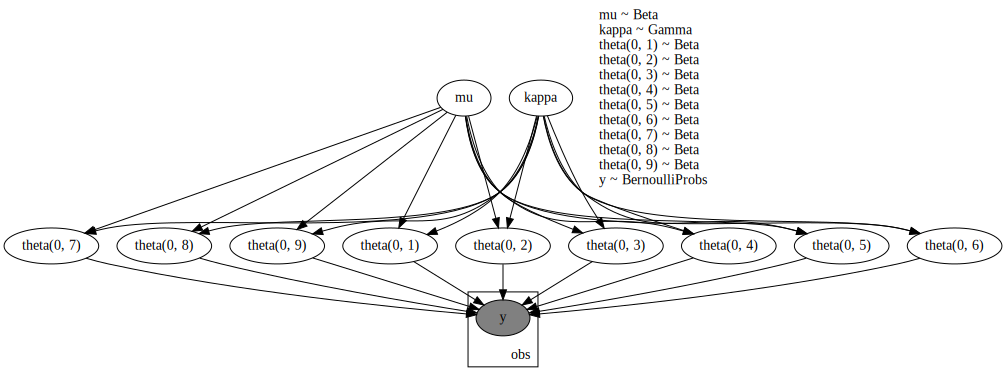

In [ ]:
numpyro.render_model(ai_model_hierarchical_model, model_args=(no_noise_obs,), render_distributions=True, render_params=True,)

In [ ]:
mcmc_hm = inference(ai_model_hierarchical_model, no_noise_obs)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
        kappa      1.98      0.42      1.95      1.28      2.65  15352.50      1.00
           mu      0.90      0.04      0.91      0.84      0.96   8473.02      1.00
  theta(0, 1)      0.99      0.03      1.00      0.96      1.00  21398.62      1.00
  theta(0, 2)      0.99      0.03      1.00      0.96      1.00  21950.80      1.00
  theta(0, 3)      0.99      0.03      1.00      0.96      1.00  22061.16      1.00
  theta(0, 4)      0.99      0.03      1.00      0.96      1.00  22479.58      1.00
  theta(0, 5)      0.46      0.12      0.46      0.26      0.66  15909.87      1.00
  theta(0, 6)      0.99      0.03      1.00      0.96      1.00  21221.87      1.00
  theta(0, 7)      0.99      0.03      1.00      0.96      1.00  21797.92      1.00
  theta(0, 8)      0.99      0.03      1.00      0.96      1.00  21815.89      1.00
  theta(0, 9)      0.99      0.03      1.00      0.96      1.00  22214.22  

### $2^{nd}$ Try

Now let's generate a data matrix using our observations.

Each $entry$ in our observation list consists of:

$entry[0]:$ (previous) state \
$entry[1]:$ action \
$entry[2]:$ next state

So we will iterate over the observation list and create a data matrix as such:

Action (key)       | Num. of Attempts  | Num. of Successes
-------------------|------------------ | ------------------
(0,1)              | 15                | 11
(0,2)              | 15                | 13
(0,3)              | 15                | 9
(0,4)              | 15                | 15
(0,5)              | 15                | 6
(0,6)              | 15                | 10
(0,7)              | 15                | 14
(0,8)              | 15                | 15
(0,9)              | 15                | 12


We will model it as explained in the 'Partial Pooling - Hierarchical Model
' text block.

$p(y_i|n_i,θ_i) \sim Binomial(n_i,\theta_i)$


In [ ]:
def gen_data_matrix(obs):
    data_dict = {}
    for entry in obs:
        key = entry[1]
        attempts = 1
        successes = 1 if entry[0] != entry[2] else 0

        if key in data_dict:
            data_dict[key]['attempts'] += attempts
            data_dict[key]['successes'] += successes
        else:
            data_dict[key] = {'attempts': attempts, 'successes': successes}

    data_matrix = []
    for key in sorted(data_dict.keys()):
        attempts = data_dict[key]['attempts']
        successes = data_dict[key]['successes']
        data_matrix.append((key, attempts, successes))

    data_matrix.sort()

    for entry in data_matrix:
        print(f"Key: {entry[0]}, Attempts: {entry[1]}, Successes: {entry[2]}, Ratio: {entry[2]/entry[1]}")

    ratios = [entry[2] / entry[1] for entry in data_matrix]

    hist, bins, _ = plt.hist(ratios, edgecolor='k', bins='auto')
    plt.xlabel("Success/Attempt Ratio")
    plt.ylabel("Count of Entries")
    plt.title("Success/Attempt Ratio Distribution")
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, int(max(hist)) + 1))
    plt.show()

    return data_matrix

Key: (0, 1), Attempts: 15, Successes: 15, Ratio: 1.0
Key: (0, 2), Attempts: 15, Successes: 15, Ratio: 1.0
Key: (0, 3), Attempts: 15, Successes: 15, Ratio: 1.0
Key: (0, 4), Attempts: 15, Successes: 15, Ratio: 1.0
Key: (0, 5), Attempts: 15, Successes: 6, Ratio: 0.4
Key: (0, 6), Attempts: 15, Successes: 15, Ratio: 1.0
Key: (0, 7), Attempts: 15, Successes: 15, Ratio: 1.0
Key: (0, 8), Attempts: 15, Successes: 15, Ratio: 1.0
Key: (0, 9), Attempts: 15, Successes: 15, Ratio: 1.0


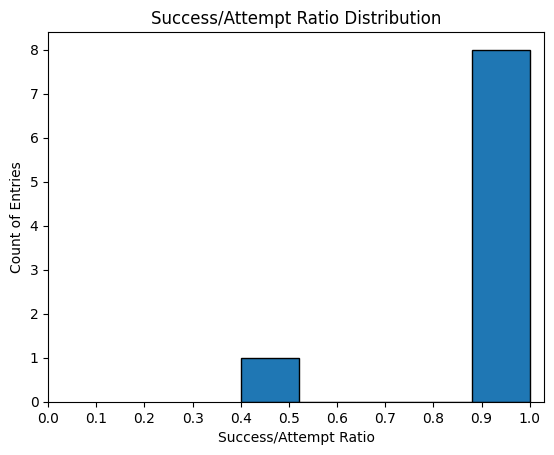

In [ ]:
data_matrix = gen_data_matrix(no_noise_obs)

In [ ]:
def ai_model_hierarchical_model_2(obs=None):
    mu = numpyro.sample("mu", dist.Beta(3,1))
    kappa = numpyro.sample("kappa", dist.Gamma(20, 10))
    attempts = jnp.array([entry[1] for entry in obs])
    successes = jnp.array([entry[2] for entry in obs])
    keys = jnp.array([entry[0] for entry in obs])
    with numpyro.plate("key_actions", size=len(obs)):
        theta = numpyro.sample(f"theta", dist.Beta(mu*kappa, (1-mu)*kappa))
        return numpyro.sample("y", dist.Binomial(total_count=attempts, probs=theta), obs=successes)

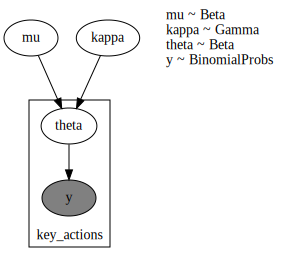

In [ ]:
numpyro.render_model(ai_model_hierarchical_model_2, model_args=(data_matrix,), render_distributions=True, render_params=True,)

In [ ]:
mcmc_hm_2 = inference(ai_model_hierarchical_model_2, data_matrix)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     kappa      1.99      0.43      1.95      1.25      2.65  13212.54      1.00
        mu      0.90      0.04      0.91      0.84      0.96   9212.32      1.00
  theta[0]      0.99      0.03      1.00      0.96      1.00  22800.55      1.00
  theta[1]      0.99      0.03      1.00      0.96      1.00  21439.73      1.00
  theta[2]      0.99      0.03      1.00      0.96      1.00  22191.11      1.00
  theta[3]      0.99      0.03      1.00      0.96      1.00  21779.32      1.00
  theta[4]      0.46      0.12      0.46      0.26      0.66  17808.58      1.00
  theta[5]      0.99      0.03      1.00      0.96      1.00  21677.59      1.00
  theta[6]      0.99      0.03      1.00      0.96      1.00  21539.75      1.00
  theta[7]      0.99      0.03      1.00      0.96      1.00  22351.50      1.00
  theta[8]      0.99      0.03      1.00      0.96      1.00  20308.74      1.00

Number of divergences: 0


In [ ]:
def summarize_hm_posterior(mcmc_arg):
    posterior_samples = mcmc_arg.get_samples()

    plt.figure()
    plt.hist(posterior_samples["mu"], bins=50, density=True)
    plt.axvline(posterior_samples["mu"].mean(), ls="dashed", color="red", label="mean")
    plt.title("Posterior for mu")
    plt.legend()
    plt.show()

    plt.figure()
    plt.hist(posterior_samples["kappa"], bins=50, density=True)
    plt.axvline(posterior_samples["kappa"].mean(), ls="dashed", color="red", label="mean")
    plt.title("Posterior for kappa")
    plt.legend()
    plt.show()

    theta_samples = posterior_samples['theta']
    for i,key in enumerate(model_beta_parameters.keys()):
        plt.figure()
        # real_param = utils.REAL_MODEL_PARAMETERS[key]
        plt.hist(theta_samples[:, i], bins=30, density=True, alpha=0.5)
        plt.axvline(theta_samples[:, i].mean(), ls="dashed", color="red", label="mean")
        # plt.axvline(real_param, ls="dashed", color="green", label="true prob.")
        plt.title(f"Posterior distribution of theta for Key {key}")
        plt.xlabel("theta")
        plt.ylabel("Density")
        plt.legend()

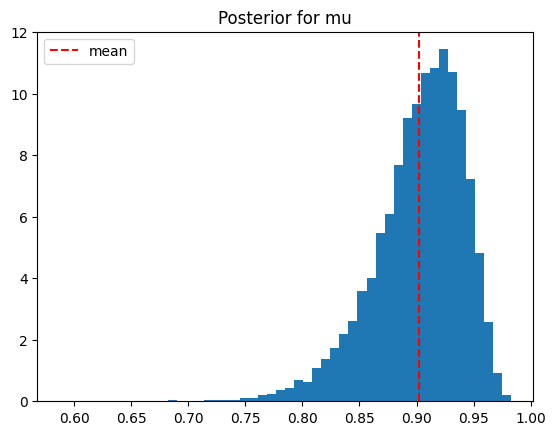

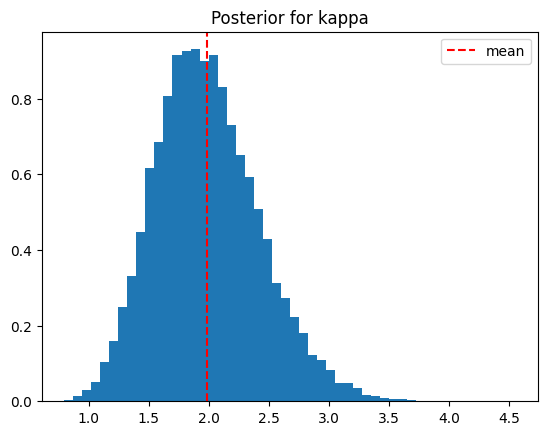

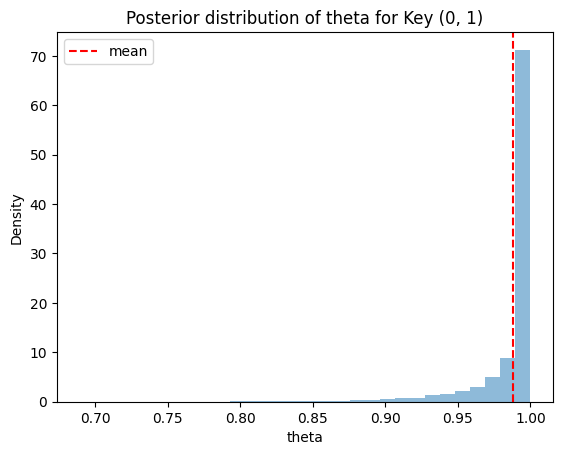

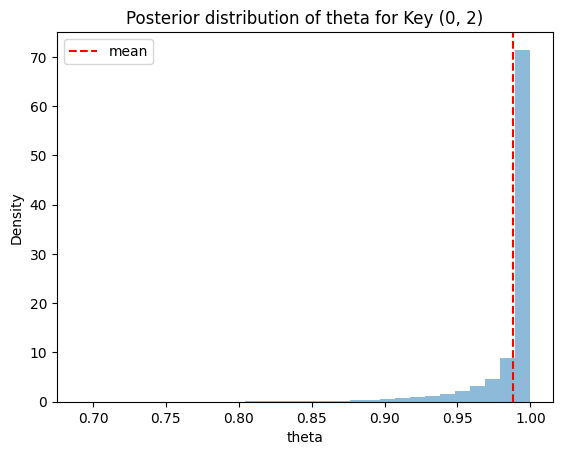

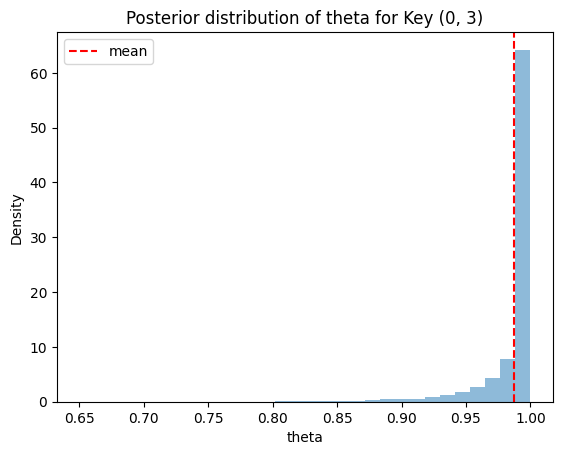

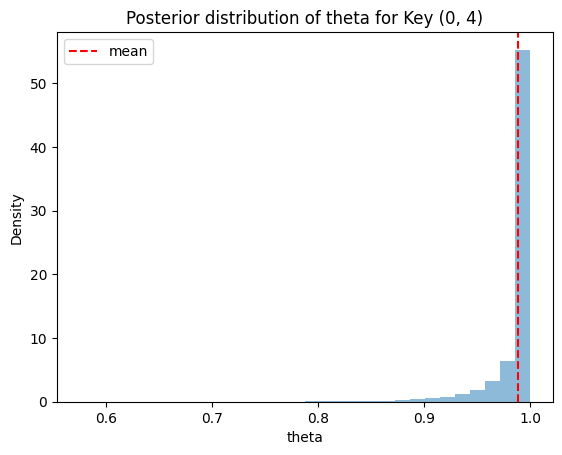

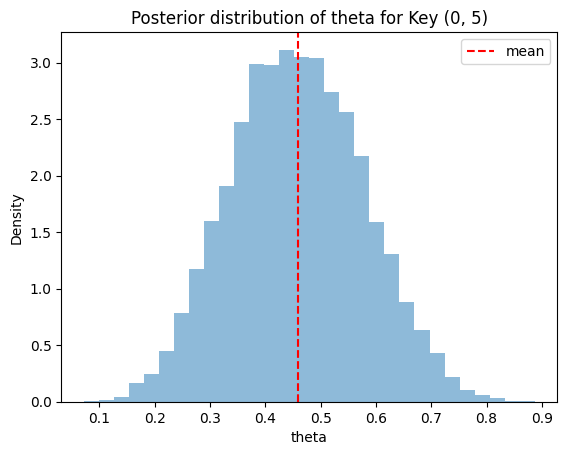

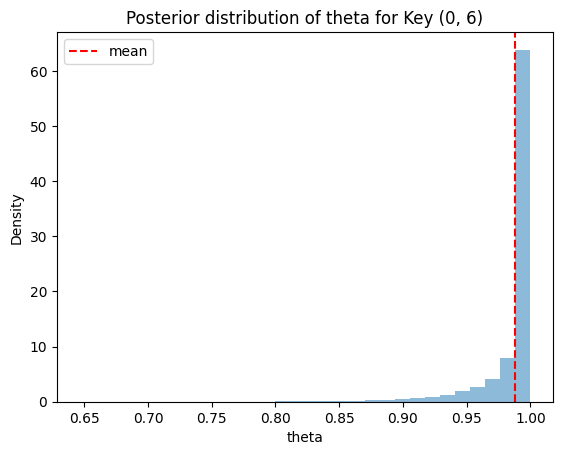

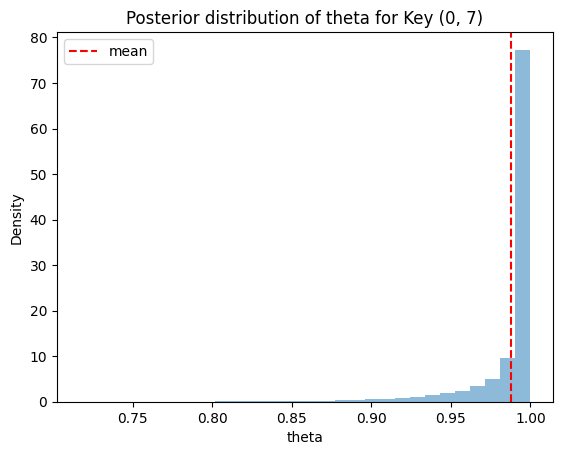

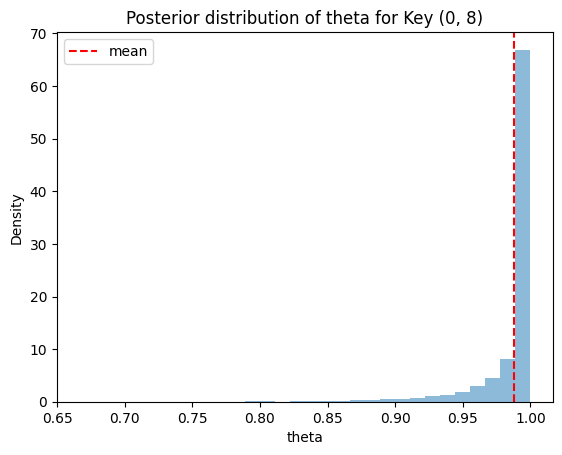

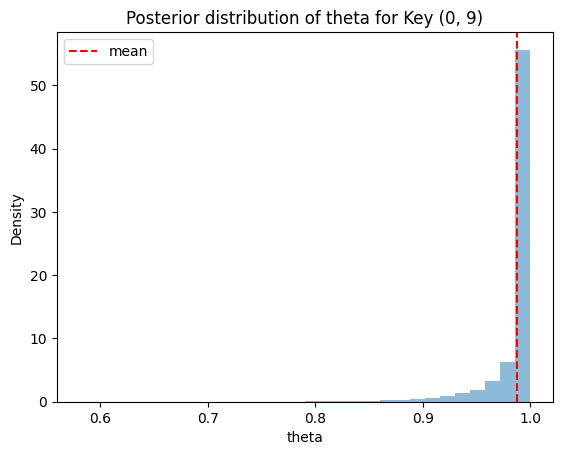

In [ ]:
summarize_hm_posterior(mcmc_hm_2)

Let's assume we have a new action - ('ai_mark', 10), but dont have any data points that we can infer the transfer probability from.

This is where our partial pooling comes in use.
Using our previous data points and actions, we could infer about the relationships between different actions ($\mu$ and $\kappa$).

Let us try to present what ('ai_mark', 10) transfer probability might look like given $\mu$ and $\kappa$

theta mean: 0.9003553986549377


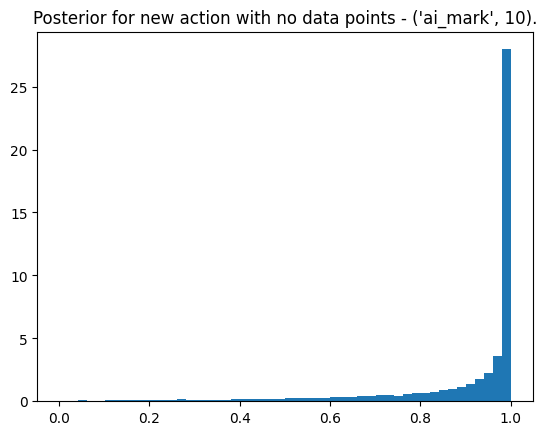

In [ ]:
posterior_samples = mcmc_hm_2.get_samples()
prior_new = []
rng_key = jax.random.PRNGKey(0)

for i in range(posterior_samples["mu"].shape[0]):
    rng_key, theta_key = jax.random.split(rng_key, 2)
    mu = posterior_samples["mu"][i]
    kappa = posterior_samples["kappa"][i]
    theta_new = numpyro.sample(f"theta_new", dist.Beta(mu * kappa, (1 - mu) * kappa), rng_key=theta_key)
    prior_new.append(theta_new)
print(f"theta mean: {np.mean(prior_new)}")
plt.hist(prior_new, bins=50, density=True)
plt.title("Posterior for new action with no data points - ('ai_mark', 10).")
plt.show()

Let's examine the difference between partial pooling and no pooling

In [ ]:
def ai_model_no_pooling(obs=None):
    attempts = jnp.array([entry[1] for entry in obs])
    successes = jnp.array([entry[2] for entry in obs])
    keys = jnp.array([entry[0] for entry in obs])
    with numpyro.plate("key_actions", size=len(obs)):
        theta = numpyro.sample(f"theta", dist.Beta(1,1))
        return numpyro.sample("y", dist.Binomial(total_count=attempts, probs=theta), obs=successes)

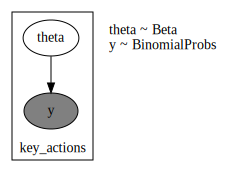

In [ ]:
numpyro.render_model(ai_model_no_pooling, model_args=(data_matrix,), render_distributions=True, render_params=True,)

In [ ]:
mcmc_np = inference(ai_model_no_pooling, data_matrix)

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.94      0.06      0.96      0.86      1.00  24527.70      1.00
  theta[1]      0.94      0.05      0.96      0.87      1.00  27524.70      1.00
  theta[2]      0.94      0.05      0.96      0.87      1.00  25915.22      1.00
  theta[3]      0.94      0.06      0.96      0.87      1.00  24026.29      1.00
  theta[4]      0.41      0.12      0.41      0.22      0.60  21495.57      1.00
  theta[5]      0.94      0.06      0.96      0.87      1.00  28433.05      1.00
  theta[6]      0.94      0.05      0.96      0.87      1.00  23815.42      1.00
  theta[7]      0.94      0.05      0.96      0.87      1.00  29051.26      1.00
  theta[8]      0.94      0.05      0.96      0.87      1.00  26475.62      1.00

Number of divergences: 0


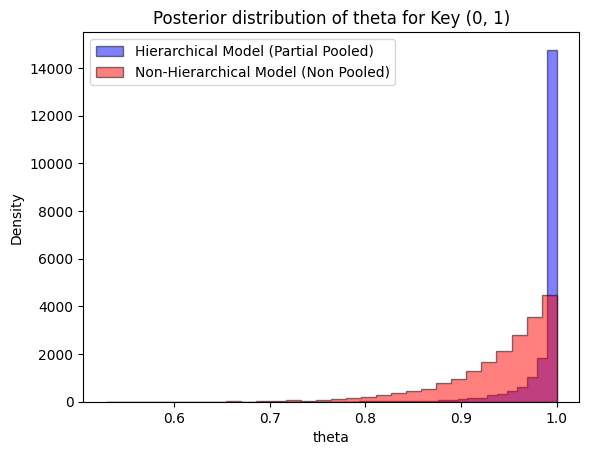

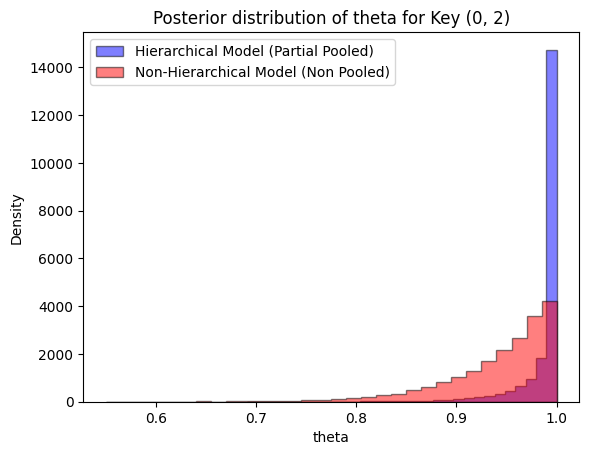

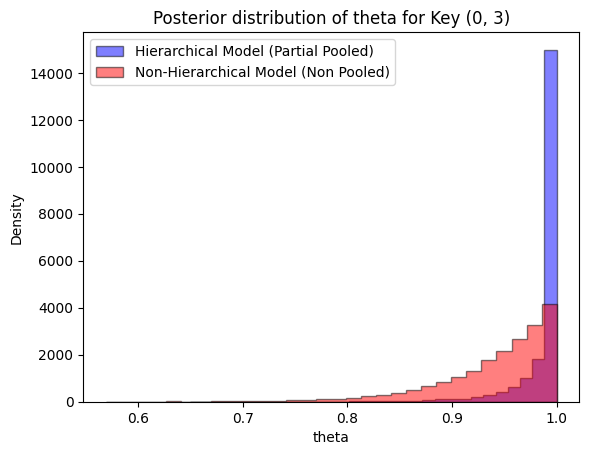

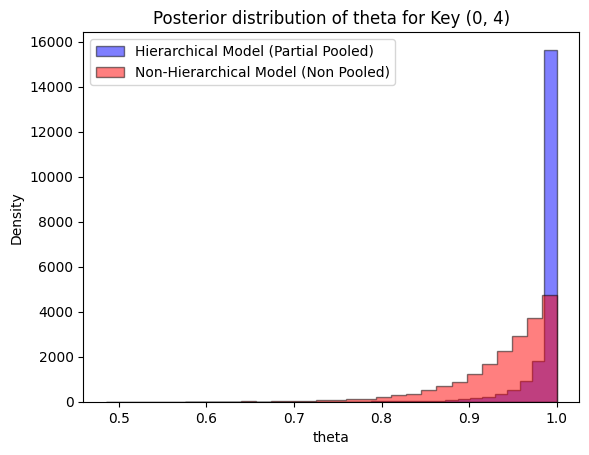

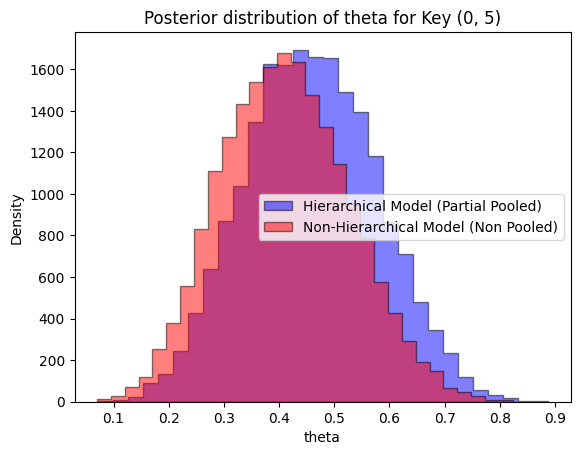

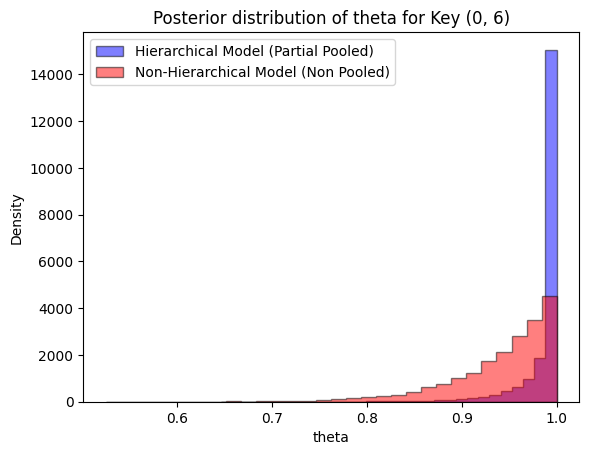

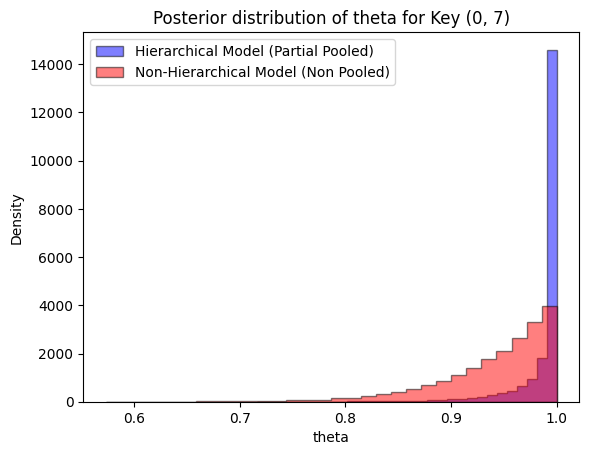

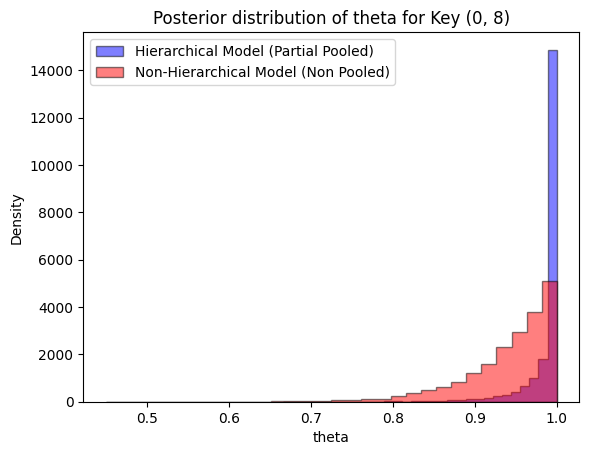

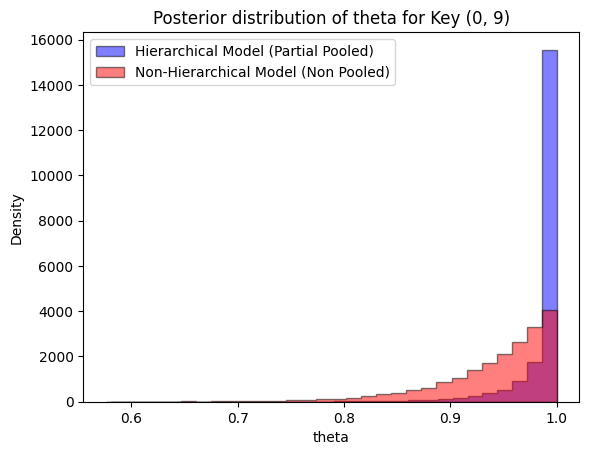

In [ ]:
theta_hm_2 = mcmc_hm_2.get_samples()['theta']
theta_np = mcmc_np.get_samples()['theta']

for i,key in enumerate(model_beta_parameters.keys()):
    plt.figure()
    # real_param = utils.REAL_MODEL_PARAMETERS[key]
    # plt.hist(theta_samples[:, i], bins=30, density=True, alpha=0.5)
    plt.hist(theta_hm_2[:, i], histtype= "stepfilled", bins=30, label='Hierarchical Model (Partial Pooled)', alpha=0.5, color='blue', edgecolor='k')
    plt.hist(theta_np[:, i], histtype= "stepfilled", bins=30, label='Non-Hierarchical Model (Non Pooled)', alpha=0.5, color='red', edgecolor='k')
    # plt.axvline(theta_samples[:, i].mean(), ls="dashed", color="red", label="mean")
    # plt.axvline(real_param, ls="dashed", color="green", label="true prob.")
    plt.title(f"Posterior distribution of theta for Key {key}")
    plt.xlabel("theta")
    plt.ylabel("Density")
    plt.legend()

We can see that for Hierarchical Model we are getting more accurate posterior distributions. This is expected because we are considering an overarching success probability that influences all cells, as opposed to the Non-Hierarchical Model, where we fit separate models for each group, treating them independently with no information sharing.

### $3^{rd}$ Try

Now let's try to add noise into our observations / model.

Let's assume deterministic noise - we know the actual probability for noise for each cell (as it is defined in the text cells above).
And we do not want to infer these parameters.

\begin{align}
        \text{Noise_Probability} = 0.15
\end{align}

**Observed Variables:**
>$y_i$: Number of overall successes when marking 'O' in cell\
$n_i$: Number of overall attempts to mark 'O' in cell

**Latent Variables:**
>$\theta_i$: True probability to successfully mark 'O' in cell

**Probabilities:**
>$p(y_i | n_i, \theta_i) \sim \text{Binomial}(n_i, \theta_i)$\
$p(\theta_i | \mu, \kappa) \sim \text{Beta}(\mu \kappa, (1-\mu)\kappa)$

**Hyperparameters:**
>$\mu \sim \text{Beta}(8, 2)$\
$\kappa \sim \text{Gamma}(1, 0.1)$

**Model:**
>$\mu \sim \text{Beta}(8, 2)$ \\
$\kappa \sim \text{Gamma}(1, 0.1)$ \\
$\text{for each } i \text{ in } \text{len(obs)}:$ \\
$\quad \theta_i \sim \text{Beta}(\mu \kappa, (1-\mu)\kappa)$ \\
$\quad \text{noise} \sim \text{Bernoulli}(\text{Noise_Probability})$ \\
\begin{align}
    \quad \text{theta_with_noise} &= \begin{cases}
        \theta_i & \text{if noise = 0} \\
        1 - \theta_i & \text{if noise = 1}
    \end{cases} \\
    \end{align}
$\quad y_i \sim \text{Binomial}(\text{total_count} = \text{attempts}[i], \text{probs} = \text{theta_with_noise}) \text{, observed} = \text{successes}[i]$


In [ ]:
# noise_probabilities = [0.3, 0.3, 0.2, 0.05, 0.4, 0.15, 0.0, 0.0, 0.1]
noise_probabilities = [0.15] * 9
noise_obs = create_synthetic_obs(noise_probabilities)
noise_obs[:9]

[([0, -1, 1, -1, 1, 1, 0, -1, 1], (0, 1), [1, -1, 1, -1, 1, 1, 0, -1, 1]),
 ([-1, 0, -1, 0, 0, 0, 0, -1, 1], (0, 2), [-1, 0, -1, 0, 0, 0, 0, -1, 1]),
 ([-1, 0, 0, 0, 0, 1, 1, 0, -1], (0, 3), [-1, 0, 1, 0, 0, 1, 1, 0, -1]),
 ([0, 0, 1, 0, 1, 0, 1, 1, 0], (0, 4), [0, 0, 1, 1, 1, 0, 1, 1, 0]),
 ([0, -1, -1, -1, 0, 0, -1, -1, 0], (0, 5), [0, -1, -1, -1, 0, 0, -1, -1, 0]),
 ([0, 0, 0, 0, 1, 0, -1, -1, -1], (0, 6), [0, 0, 0, 0, 1, 1, -1, -1, -1]),
 ([0, 1, -1, -1, -1, 0, 0, -1, -1], (0, 7), [0, 1, -1, -1, -1, 0, 1, -1, -1]),
 ([0, -1, -1, -1, -1, 0, 1, 0, 0], (0, 8), [0, -1, -1, -1, -1, 0, 1, 1, 0]),
 ([0, 0, 1, -1, 1, 1, 0, 0, 0], (0, 9), [0, 0, 1, -1, 1, 1, 0, 0, 1])]

In [ ]:
def ai_model_hm_noise(obs=None):
    mu = numpyro.sample("mu", dist.Beta(3, 1))
    kappa = numpyro.sample("kappa", dist.Gamma(20, 10))
    attempts = jnp.array([entry[1] for entry in obs])
    successes = jnp.array([entry[2] for entry in obs])
    keys = jnp.array([entry[0] for entry in obs])
    noise_p = jnp.array(noise_probabilities)

    with numpyro.plate("key_actions", size=len(obs)):
        theta = numpyro.sample(f"theta", dist.Beta(mu*kappa, (1-mu)*kappa))
        noise = numpyro.sample("noise", dist.Bernoulli(noise_p))
        # noise = numpyro.param("noise", noise_p)
        theta_with_noise = jax.numpy.where(noise, 1-theta, theta)
        numpyro.sample("y", dist.Binomial(total_count=attempts, probs=theta_with_noise), obs=successes)

Key: (0, 1), Attempts: 15, Successes: 13, Ratio: 0.8666666666666667
Key: (0, 2), Attempts: 15, Successes: 12, Ratio: 0.8
Key: (0, 3), Attempts: 15, Successes: 13, Ratio: 0.8666666666666667
Key: (0, 4), Attempts: 15, Successes: 14, Ratio: 0.9333333333333333
Key: (0, 5), Attempts: 15, Successes: 8, Ratio: 0.5333333333333333
Key: (0, 6), Attempts: 15, Successes: 15, Ratio: 1.0
Key: (0, 7), Attempts: 15, Successes: 14, Ratio: 0.9333333333333333
Key: (0, 8), Attempts: 15, Successes: 12, Ratio: 0.8
Key: (0, 9), Attempts: 15, Successes: 13, Ratio: 0.8666666666666667


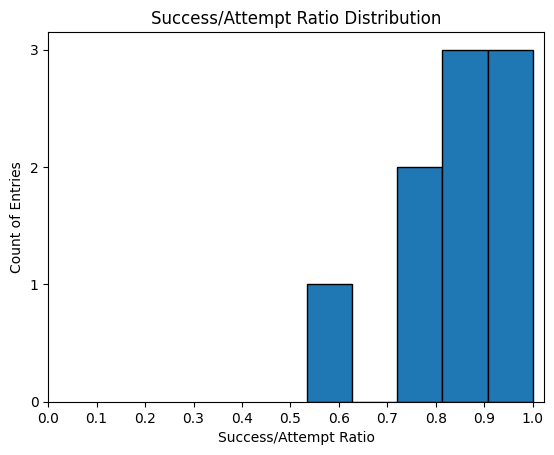

In [ ]:
data_matrix_noise = gen_data_matrix(noise_obs)

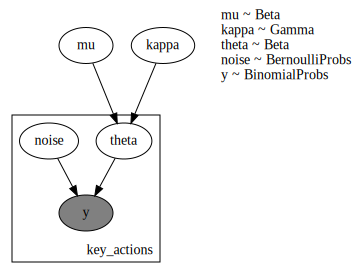

In [ ]:
numpyro.render_model(ai_model_hm_noise, model_args=(data_matrix_noise,), render_distributions=True, render_params=True,)

In [ ]:
mcmc_hm_noise = inference(ai_model_hm_noise, data_matrix_noise)

/usr/local/lib/python3.10/dist-packages/jax/_src/linear_util.py:191: FutureWarning: Some algorithms will automatically enumerate the discrete latent site noise of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     kappa      2.23      0.46      2.20      1.46      2.96   9337.51      1.00
        mu      0.76      0.08      0.76      0.64      0.88   1022.67      1.00
  theta[0]      0.84      0.13      0.86      0.71      0.98   1099.23      1.00
  theta[1]      0.77      0.14      0.80      0.62      0.96   3298.11      1.00
  theta[2]      0.83      0.14      0.86      0.71      0.98    584.80      1.01
  theta[3]      0.90      0.12      0.93      0.81      1.00    266.79      1.02
  theta[4]      0.55      0.12      0.56      0.36      0.75  20746.91      1.00
  theta[5]      0.95      0.14      0.98      0.90      1.00     44.20      1.10
  theta[6]      0.90      0.11      0.93      0.81      1.00    117.53      1.03
  theta[7]      0.77      0.15      0.80      0.62      0.96   3052.46      1.00
  theta[8]      0.83      0.14      0.86      0.71      0.98    898.39      1.01

Number of divergences: 0


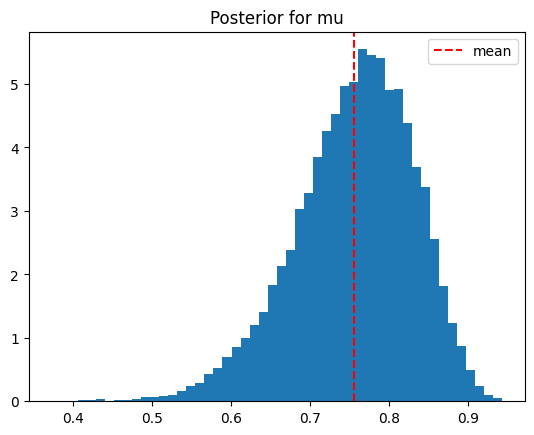

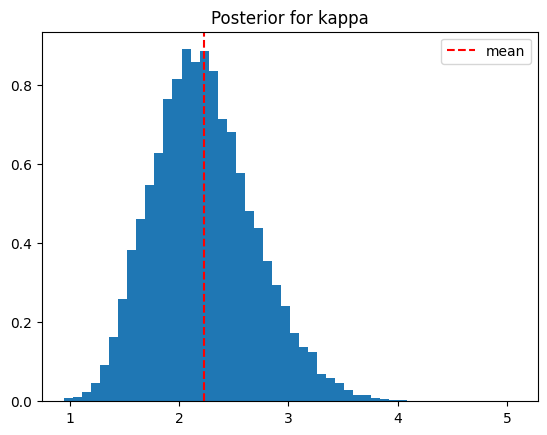

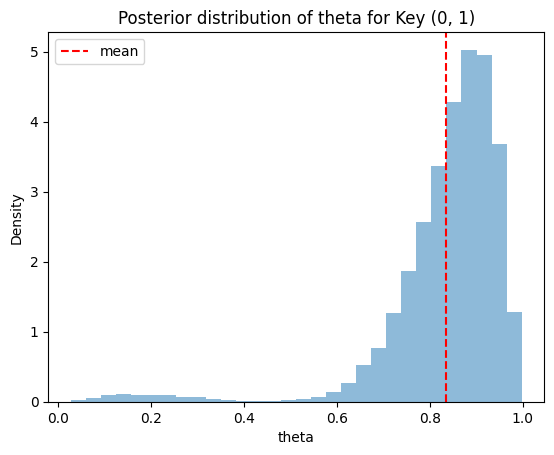

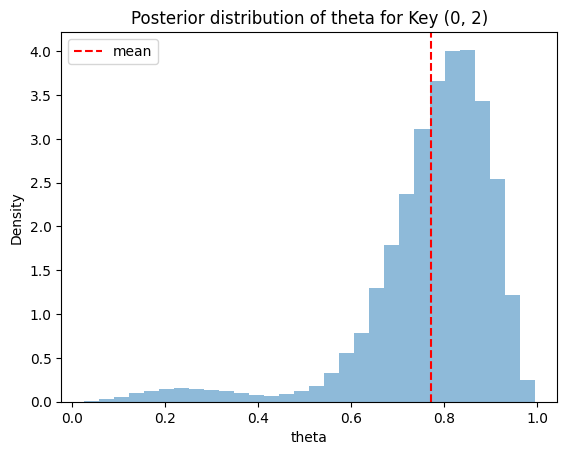

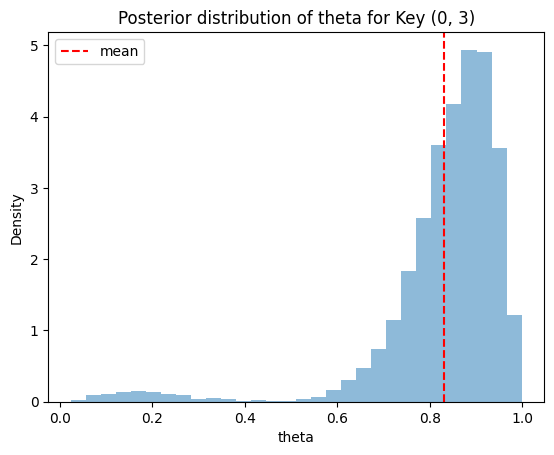

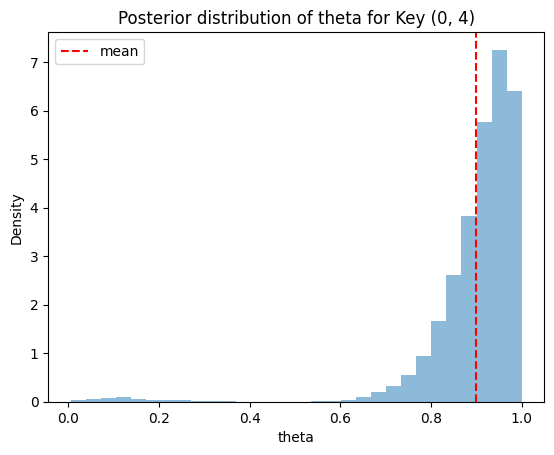

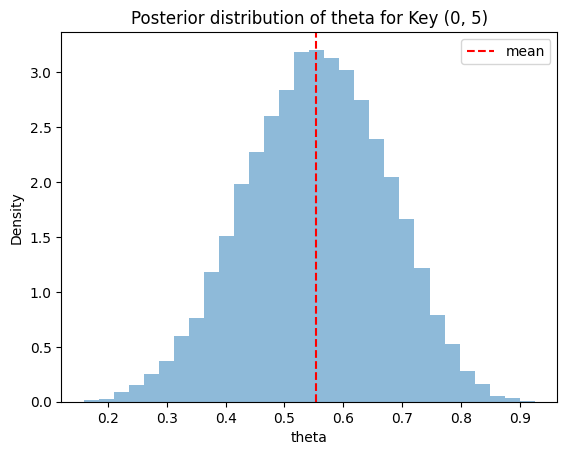

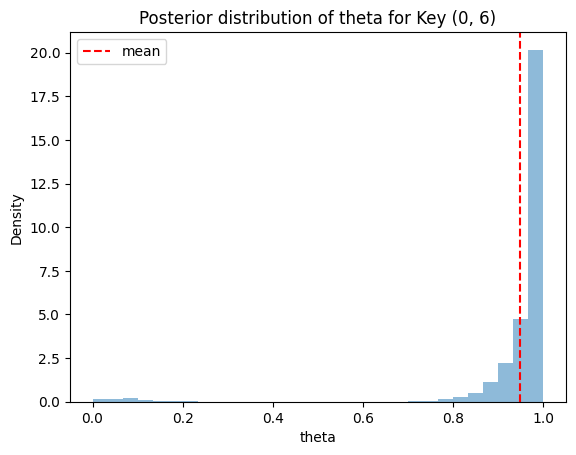

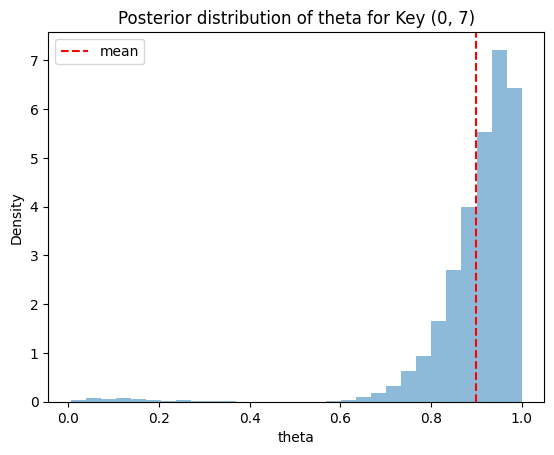

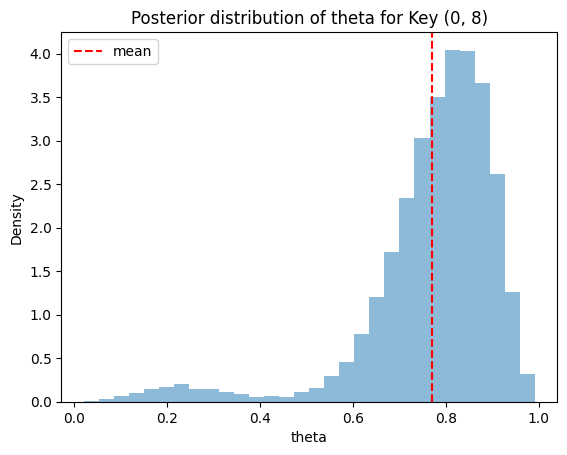

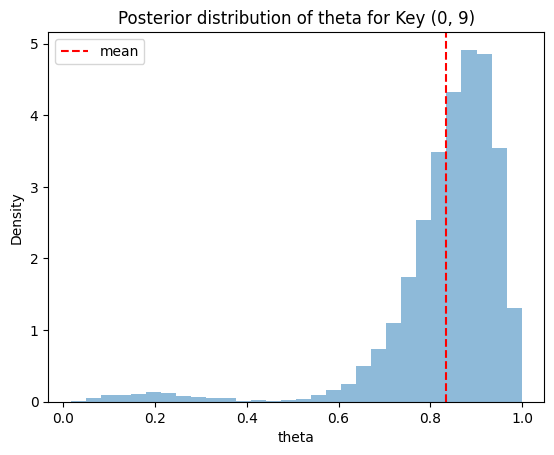

In [ ]:
summarize_hm_posterior(mcmc_hm_noise)

### $4^{th}$ Try

Now let's assume we dont know the exact value of the noise probability, but have a strong prior.

$noise \sim Beta(3,10)$

$\mu$=E(X)=0.2308\
$\sigma$=SD(X)=0.1126\
$\sigma^{2}$=Var(X)=0.0127

**Observed Variables:**
>$y_i$: Number of overall successes when marking 'O' in cell $i$\
$n_i$: Number of overall attempts to mark 'O' in cell $i$

**Latent Variables:**
>$\theta_i$: True probability to successfully mark 'O' in cell $i$

**Probabilities:**
>$p(y_i | n_i, \theta_i) \sim \text{Binomial}(n_i, \theta_i)$\
$p(\theta_i | \mu, \kappa) \sim \text{Beta}(\mu \kappa, (1-\mu)\kappa)$

**Hyperparameters:**
>$\mu \sim \text{Beta}(8, 2)$\
$\kappa \sim \text{Gamma}(1, 0.1)$

**Model:**
>$\mu \sim \text{Beta}(8, 2)$ \\
$\kappa \sim \text{Gamma}(1, 0.1)$ \\
$\text{noise} \sim \text{Beta}(3, 10)$ \\
$\text{for each } i \text{ in } \text{len(key_actions)}:$ \\
$\quad \theta_i \sim \text{Beta}(\mu \kappa, (1-\mu)\kappa)$ \\
$\quad \text{noise_outcome} \sim \text{Bernoulli}(\text{noise})$ \\
\begin{align}
    \quad \text{theta_with_noise} &= \begin{cases}
        \theta_i & \text{if noise_outcome = 0} \\
        1 - \theta_i & \text{if noise_outcome = 1}
    \end{cases} \\
    \end{align}
$\quad y_i \sim \text{Binomial}(\text{total_count} = \text{attempts}[i], \text{probs} = \text{theta_with_noise}) \text{, observed} = \text{successes}[i]$


In [ ]:
def ai_model_hm_noise_2(obs=None):
    mu = numpyro.sample("mu", dist.Beta(3, 1))
    kappa = numpyro.sample("kappa", dist.Gamma(20, 10))
    noise = numpyro.sample("noise", dist.Beta(3,10))
    attempts = jnp.array([entry[1] for entry in obs])
    successes = jnp.array([entry[2] for entry in obs])
    keys = jnp.array([entry[0] for entry in obs])

    with numpyro.plate("key_actions", size=len(obs)):
        theta = numpyro.sample("theta", dist.Beta(mu*kappa, (1-mu)*kappa))
        noise_outcome = numpyro.sample("noise_outcome", dist.Bernoulli(noise))
        theta_with_noise = jax.numpy.where(noise_outcome, 1-theta, theta)
        numpyro.sample("y", dist.Binomial(total_count=attempts, probs=theta_with_noise), obs=successes)

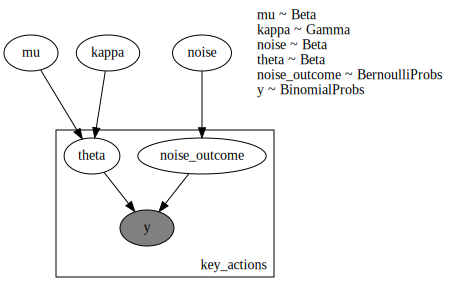

In [ ]:
numpyro.render_model(ai_model_hm_noise_2, model_args=(data_matrix_noise,), render_distributions=True, render_params=True,)

In [ ]:
mcmc_hm_noise_2 = inference(ai_model_hm_noise_2, data_matrix_noise)

/usr/local/lib/python3.10/dist-packages/jax/_src/linear_util.py:191: FutureWarning: Some algorithms will automatically enumerate the discrete latent site noise_outcome of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     kappa      2.21      0.47      2.18      1.47      2.97    679.89      1.01
        mu      0.74      0.10      0.75      0.59      0.88     49.71      1.07
     noise      0.17      0.10      0.15      0.03      0.30     92.79      1.04
  theta[0]      0.82      0.16      0.86      0.69      0.99    336.61      1.02
  theta[1]      0.76      0.16      0.80      0.60      0.97    323.92      1.02
  theta[2]      0.82      0.17      0.86      0.69      0.98    281.49      1.01
  theta[3]      0.86      0.20      0.92      0.77      1.00     96.59      1.04
  theta[4]      0.55      0.12      0.55      0.36      0.75  14720.57      1.00
  theta[5]      0.87      0.28      0.98      0.16      1.00     15.10      1.28
  theta[6]      0.86      0.21      0.92      0.76      1.00     60.78      1.06
  theta[7]      0.76      0.17      0.80      0.58      0.97    571.05      1.01
  theta[8]      0.81      0

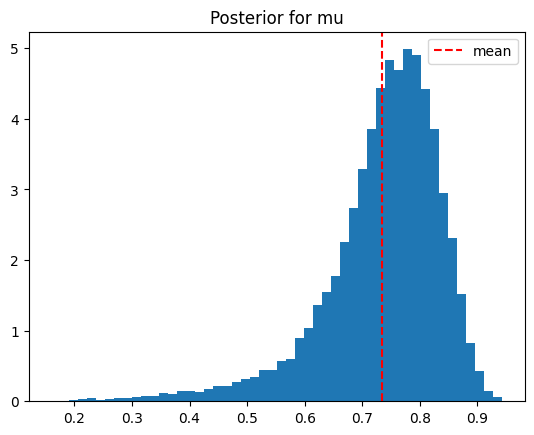

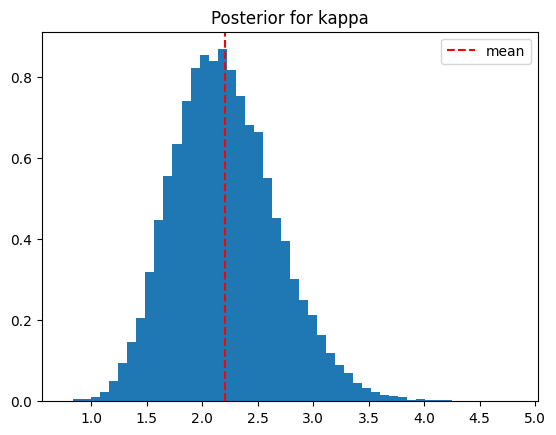

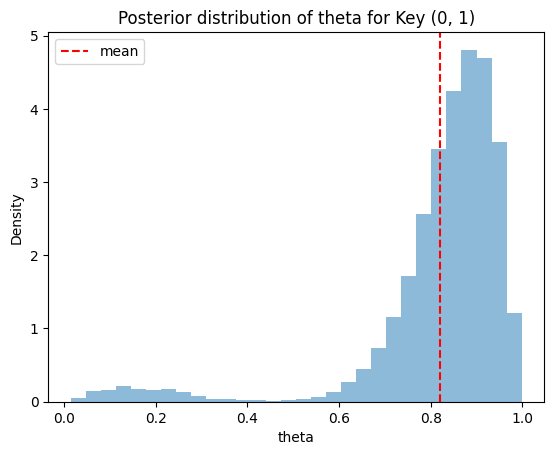

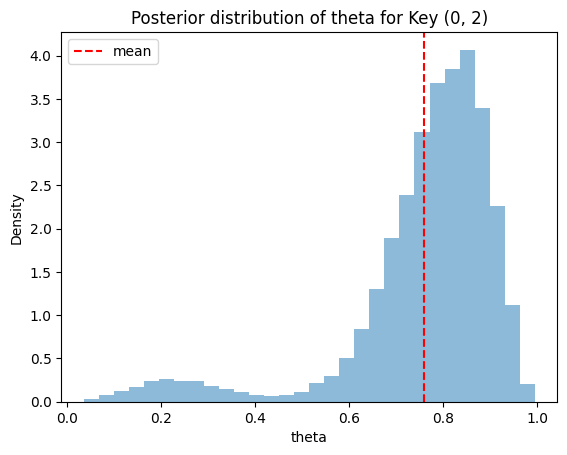

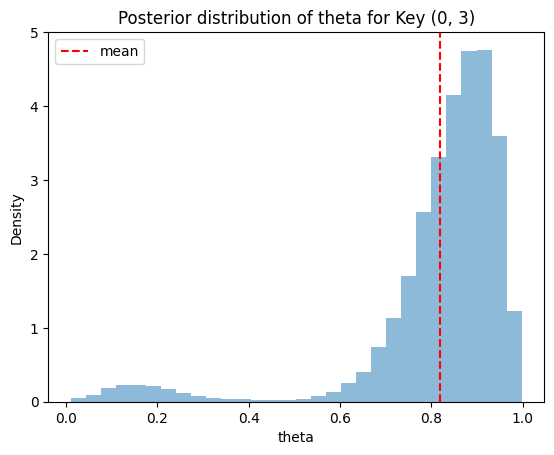

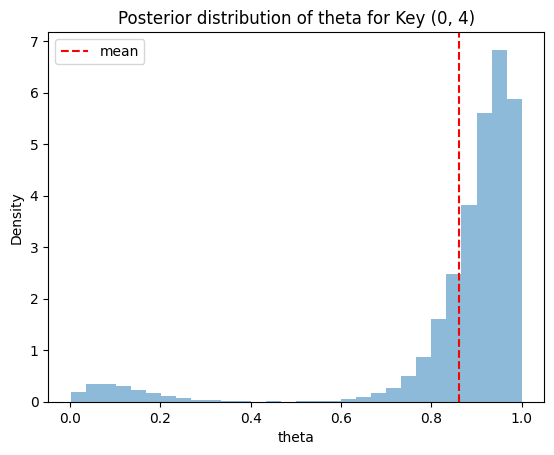

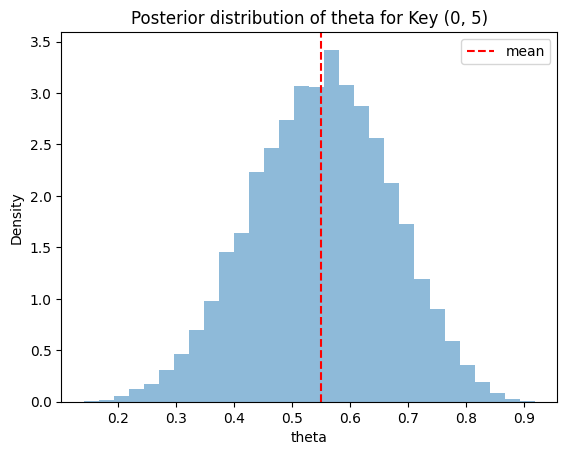

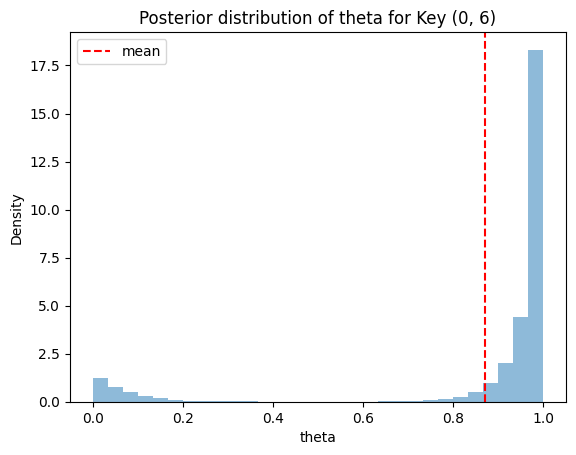

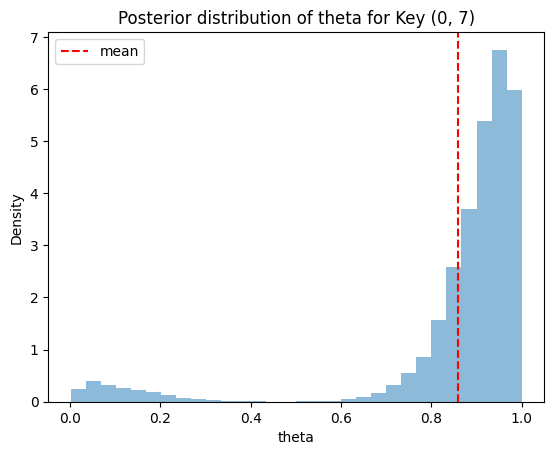

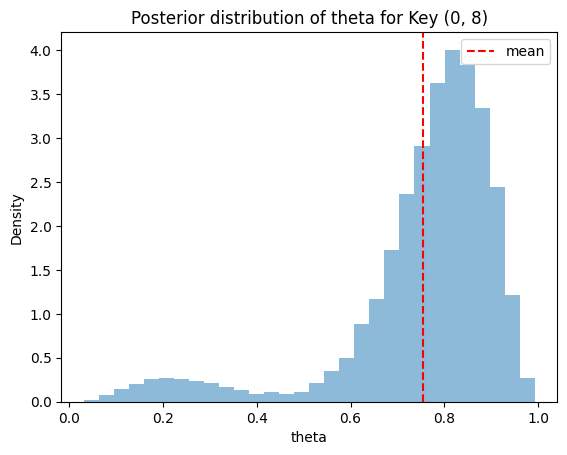

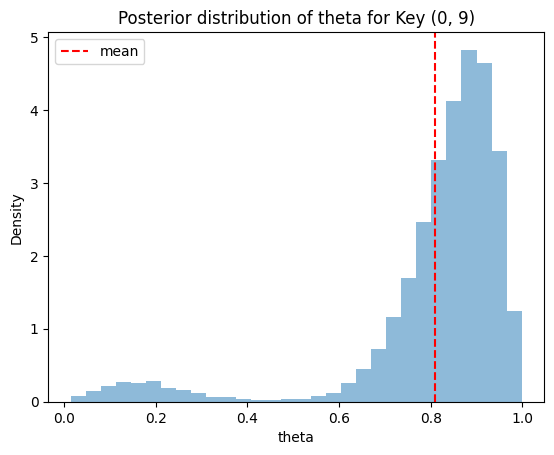

In [ ]:
summarize_hm_posterior(mcmc_hm_noise_2)

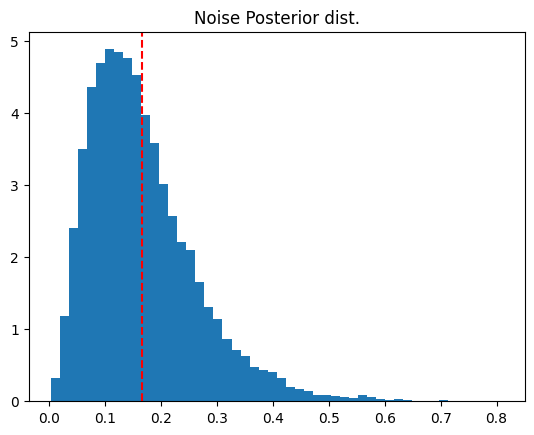

In [ ]:
posterior_samples = mcmc_hm_noise_2.get_samples()
plt.hist(posterior_samples["noise"], bins=50, density=True)
plt.axvline(posterior_samples["noise"].mean(), ls="dashed", color="red", label="mean")
plt.title("Noise Posterior dist.")
plt.show()

We can see that the noise parameter mean is exactly 0.15, which is the noise probability given when generating the observations. Meaning we were able to infer the correct value of the noise probability parameter.